# Capstone Project - Predicting Stock Prices Using Machine Learning 

## Part 2 Machine Learning

## Objective:

We want to predict future movements of stock prices using trends from the previous years.
<br><br>
Price movements of stocks exhibit noises, fluctuations and volatility, due to a number of independent and dependent variables that influence the value of a certain stock in the market. Because of this complexity, it is very challenging to correctly predict their movement with great precision.
<br><br>
The primary questions we want to answer are: <br>
__"Is it feasible to forecast stock prices, given information about its recent prices over time, and in combination with other indicators, such as economic, technical and sentiment indicators?"__
<br><br>
and:
<br><br>
__"Can we maximise our investment return using machine-learning based trading strategy?__"
<br><br>
Our stakeholders are __ordinary everyday retail-traders__, who do not have access to or have enough understanding of complex financial data.
<br><br>
The business objective of this project is to:
- Maximise investment return
Here, innvestment return is defined as __the difference between current and initial price over the initial price__. Note, however, there are other considerations to optimum stock trading strategy than just predicting the price movement, such as trading costs, slippage, tax, and risk management in general. For simplicity, we did not take these other factors into account.

The modelling objective of this project is to:
- gain insights from the dataset
- establish an architecture that can be used to predict medium- and long-term changes in stock prices
<br><br>
In this project, we describe our approach, from gathering the data, cleaning and manipulating the data and conducting exploratory data analysis to gain insights, and applying several machine learning algorithms to build the most accurate predictive model.


## Continued from Part 1:

We will import the final cleaned dataframe from Part 1 and apply several machine learning algorithms, namely:
1. Autoregressive (Simple Linear Regression using lagged features)
2. Automatic Regression Integrated Moviing Average (ARIMA)
3. Multi-Layer Perceptron (MLP, or Feedforward Neural Network)
4. Prophet
5. Long-Short Term Memory (LSTM)

__NOTES__

Notes:
 ARIMA stands for the combination of Autoregressive (AR) and Moving Average (MA) approaches within building a composite model of the time series. ARIMA models include parameters to account for season and trend (for instance, dummy variables for weekdays and they're distinguishing). In addition, they allow for the inclusion of autoregressive and moving average terms to handle the autocorrelation embedded in the data.  

Multi-Layer Perceptron (MLP)
As an applied machine learning approach, the MLP model implies the triple structure of the initial layer of the network which takes in an input, a hidden layer of nodes, and an output layer used to make a prediction.

Among the time series prediction models, the method of calculating the MAPE (Mean Absolute Percent Error) shows the best results as a quicker way to compare the overall forecast accuracy of a proposed model.  

The measures represent the percentage of average absolute error that occurred. The overall idea of calculations for the evaluation of model accuracy comes to the following proportion: the lower the MAPE, the better the forecast accuracy.

Decomposition of the Data?
1. Trend
2. Seasonality
3. Cyclical
4. Irregular

In [1]:
!pip install pmdarima ## Only needed when running on Google Colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Import All Required Libraries

In [2]:
## Numpy and Pandas Libraries
import pandas as pd
import numpy as np

## Miscellaneous Libraries
from datetime import datetime
import math
import pickle
import warnings
warnings.filterwarnings("ignore")

## Data Visualisation Modules
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm, ListedColormap
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

## Train Test Split
from sklearn.model_selection import train_test_split

## Standardisation
from sklearn.preprocessing import StandardScaler

## Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## AutoRegress
from statsmodels.tsa.ar_model import AutoReg

## ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error

## MultiOutputRegressor & XGBoost
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

## GridSearch
from sklearn.model_selection import GridSearchCV 

## SVM Regressor
from sklearn.svm import SVR

## Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

### 1.1 General Helper Functions

Note:
Some of the functions (make_lags, make_multistep_target, and plot_multistep) are from Kaggle and have been modified for the project.

In [3]:
## Helper Function for Creating Lag for Features
def make_lags(ts, col, lags, lead_time = 1):
    lag = pd.concat({f'{col}_lag_{i}': ts.shift(i) for i in range(lead_time, lags + lead_time)},
                     axis=1)

    return lag

In [4]:
## Helper Function for Creating Lag for Target
def make_multistep_target(ts, steps):
    lag = pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in range(steps)},
                    axis=1)
    
    return lag

In [5]:
## Helper Function for Plotting Graphs
def linegraph(y_actual, y_fore, base = 5):
    ## This function will be used for plotting the values of all columns except SP500.
    ## Another function will be used for SP500.
    
    ## Plot Settings
    fig, axes = plt.subplots(1, 1, figsize = (14,8))
        
    plt.rcParams['font.size'] = 20
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams['figure.facecolor'] = "white"
    plt.rcParams['axes.facecolor'] = "white"
    sns.set_theme(style='ticks', font_scale=1.4)
    
    fig.suptitle(f"Actual vs Forecast S&P 500 Index",
                 fontsize = 20)
    
    x = y_actual.index
    
    ## Actual Plot
    sns.lineplot(ax=axes,
                 x=x, 
                 y=y_actual, 
                 color = "navy",
                 ls = "-",
                 linewidth = 2,
                 label = "Actual")
    
    ## Forecast Plot
    sns.lineplot(ax=axes,
                 x=x, 
                 y=y_fore, 
                 color = "red",
                 linewidth = 3,
                 ls = ":",
                 label = "Forecast")


    axes.set_xlim(x[0])

    axes.xaxis.set_major_locator(mdates.YearLocator(base=base))
    axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    
    axes.grid(True, which='both')
    sns.despine(ax=axes, offset=0)
        
    txt = f"S&P 500 Index" 
    axes.set_ylabel(txt, fontsize = 18)
    axes.set_xlabel(f"Date (Year)", fontsize = 18)
    
    plt.show() 

In [6]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    # Set Matplotlib defaults
    plt.style.use("seaborn-whitegrid")
    plt.rc("figure", autolayout=True, figsize=(11, 4))
    plt.rc("axes",
           labelweight="bold",
           labelsize="large",
           titleweight="bold",
           titlesize=16,
           titlepad=10)
    
    plot_params = dict(color="0.75",
                       style=".-",
                       markeredgecolor="0.25",
                       markerfacecolor="0.25")
    
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

### 1.2 Import Pickled Dataframe

In [7]:
!pip3 install pickle5 ## Only needed when running on Google Colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pickle5 as pickle ## Only needed when running on Google Colab

In [9]:
with open("/content/df_copy.pkl", "rb") as fh: ## Only needed when running on Google Colab
  df = pickle.load(fh)

In [ ]:
# df = pd.read_pickle("df_copy.pkl") 

In [10]:
df.head()

gold       gdp  unemploy  med_income  con_sentiment    oil  \
1990-01-01  398.6  5872.701    6752.0     57677.0           93.0  21.20   
1990-01-02  399.0  5872.701    6752.0     57677.0           93.0  21.20   
1990-01-03  395.0  5872.701    6752.0     57677.0           93.0  22.65   
1990-01-04  396.5  5872.701    6752.0     57677.0           93.0  22.50   
1990-01-05  405.0  5872.701    6752.0     57677.0           93.0  23.13   

                   SMA    EWMA_200  upper_band  lower_band  ...   s_score  \
1990-01-01  344.046799  331.337663  355.562514  332.531083  ...  0.518557   
1990-01-02  344.046799  331.337663  355.562514  332.531083  ...  0.513476   
1990-01-03  344.278799  331.610522  356.496513  332.061084  ...  0.508329   
1990-01-04  344.495599  331.849920  357.130810  331.860389  ...  0.503116   
1990-01-05  344.665599  332.052408  357.484510  331.846689  ...  0.497839   

                   ftse          hsi   tnx        vix       volume  \
1990-01-01  2434.100098  2838.100098  7.94  17.240000  162070000.0   
1990-01-02  2434.100098  2838.100098  7.94  17.240000  162070000.0   
1990-01-03  2463.699951  2858.699951  7.99  18.190001  192330000.0   
1990-01-04  2451.600098  2868.000000  7.98  19.219999  177000000.0   
1990-01-05  2444.500000  2839.899902  7.99  20.110001  158530000.0   

                  open        high         low       close  
1990-01-01  353.399994  359.690002  351.980011  359.690002  
1990-01-02  353.399994  359.690002  351.980011  359.690002  
1990-01-03  359.690002  360.589996  357.890015  358.760010  
1990-01-04  358.760010  358.760010  352.890015  355.670013  
1990-01-05  355.670013  355.670013  351.350006  352.200012  

[5 rows x 22 columns]

In [11]:
df.columns

Index(['gold', 'gdp', 'unemploy', 'med_income', 'con_sentiment', 'oil', 'SMA',
       'EWMA_200', 'upper_band', 'lower_band', 'band_gap', 'RSI', 's_score',
       'ftse', 'hsi', 'tnx', 'vix', 'volume', 'open', 'high', 'low', 'close'],
      dtype='object')

In [12]:
df.close.head()

1990-01-01    359.690002
1990-01-02    359.690002
1990-01-03    358.760010
1990-01-04    355.670013
1990-01-05    352.200012
Name: close, dtype: float64

## 2. Fixed Statistical Test

In [ ]:
## Helper Function for Augmented Dickey-Fuller Test
## Tests for stationarity (existence of trend) of the data
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)


In [ ]:
adf_test(df.close)

1. ADF :  1.829504551032574
2. P-Value :  0.9984057740357631
3. Num Of Lags :  36
4. Num Of Observations Used For ADF Regression: 9720
5. Critical Values :
	 1% :  -3.431022945246449
	 5% :  -2.8618374008251553
	 10% :  -2.5669283013366018


Analysis:
- If p < 0.05, the data is stationary, else it is non-stationary.
- Our p-value is 0.998, which means the data is not stationary. This indicates presence of certain trends (varying mean) or seasonality.


## 3. Autoregressive Model

We wil start with the simplest of the classical statistical model - Autoregressive Model.
It is basically a simple model that predicts future values based on past values.
In other words, an autoregressive model is when a value from a time series is regressed on previous values from that same time series.

In [ ]:
# Create training and test data
y_train = df.close[:len(df)-540]
y_test = df.close[len(df)-540:]

In [ ]:
## Find the optimal lag that gives the lowest rmse score
lags = np.linspace(start = 1, stop = 200, num = 200)

train_rmse_list = []
test_rmse_list = []

for lag in lags:
    lag = int(lag)
    ar_model = AutoReg(y_train, lags=lag).fit()

    y_fit = ar_model.predict(start=lag+1, end=len(y_train), dynamic=False)
    y_pred = ar_model.predict(start=len(y_train), end=(len(df)-1), dynamic=False)
    
    train_rmse = np.sqrt(mean_squared_error(y_train[lag:], y_fit))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

In [ ]:
print("Lowest Training RMSE:", np.argmin(train_rmse_list))

Lowest Training RMSE: 0


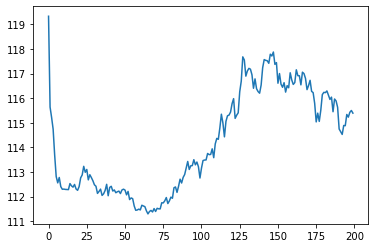

In [ ]:
plt.plot(test_rmse_list)

In [ ]:
np.argmin(test_rmse_list)

65

The lowest test rmse is given when lag = 65.

In [ ]:
lags = 65

ar_model = AutoReg(y_train, lags=lags).fit()

y_fit = ar_model.predict(start=lags+1, end=len(y_train), dynamic=False)
y_pred = ar_model.predict(start=len(y_train), end=(len(df)-1), dynamic=False)


/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train[lags:], y_fit))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 1.69
Test RMSE: 111.42


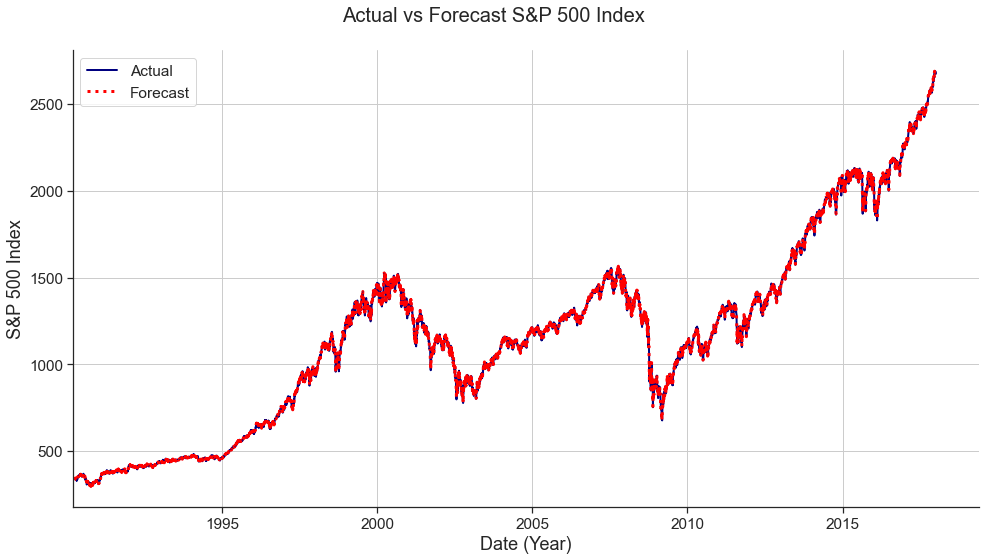

In [ ]:
linegraph(y_train[lags:], y_fit, base = 5)

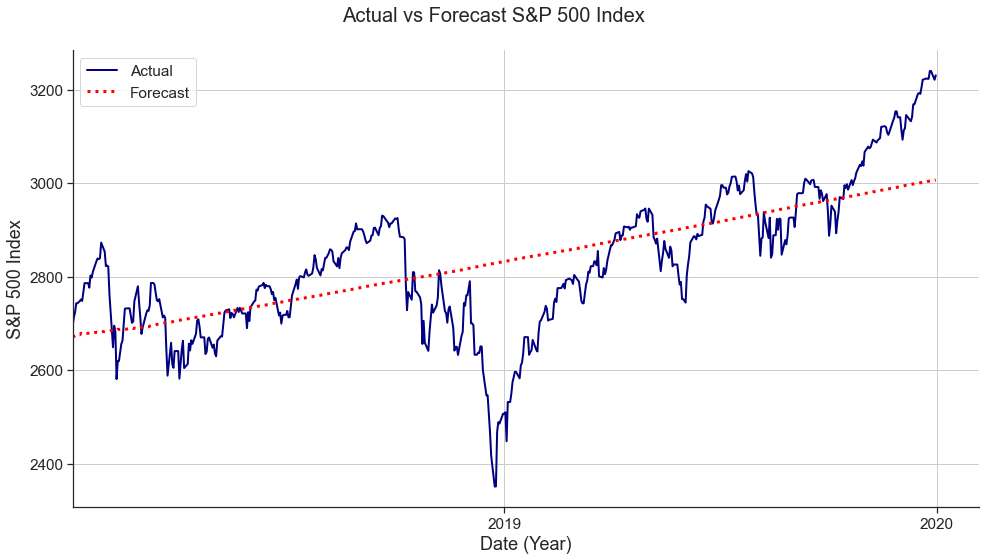

In [ ]:
linegraph(y_test, y_pred.values, base = 1)

In [ ]:
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Test MAPE: {test_mape:.2f}")

Test RMSE: 0.03


Analysis:
- The model learnt perfectly from the training dataset, which resulted in overfitting. This will be a common problem for all other regression models.
- The forecast is basically a straight line showing the general trend of future prices.
- This give test RMSE of 111.42 and MAPE of 0.03 (3% average error). This will be our baseline scores

## 4. ARIMA Model

ARIMA is composed of 3 terms:
1. Auto-Regression (using the previous values of the time series in order to predict the future)
2. Integrated (differencing with the previous value to make the data stationary, y(t) - y(t-1))
3. Moving Average (using previous errors to make future predictions)
<br><br>
Requires the order of the AR, I, and MA parts which are donated by (p, d, q), respectively.

In [ ]:
y = df.close

In [ ]:
stepwise_fit = auto_arima(y, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=76725.595, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76750.429, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76732.824, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76732.349, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76753.960, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=76723.569, Time=2.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=76733.163, Time=1.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=76725.406, Time=2.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=76725.156, Time=5.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=76735.161, Time=1.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=76732.205, Time=3.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=76724.892, Time=4.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=76729.600, Time=0.92 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 24.696 seconds


Analysis:
The best ARIMA hyperparameters to use, as suggested by auto arima, are p = 1, d = 1, and q = 2.

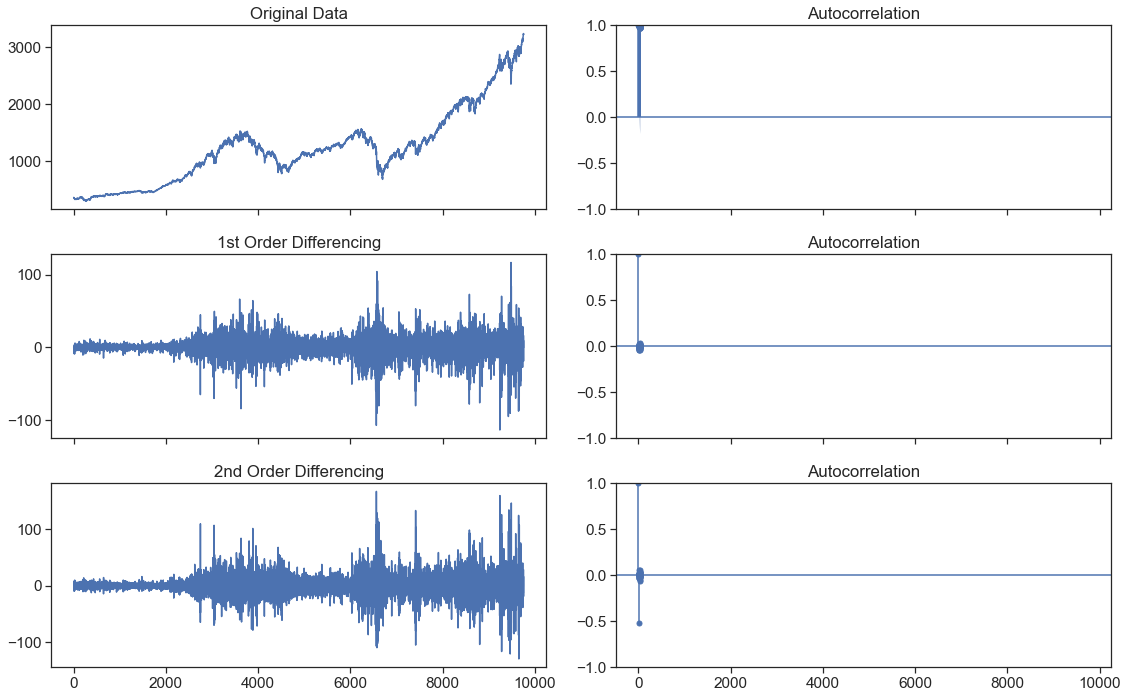

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(16,10))
axes[0, 0].plot(y.values)
axes[0, 0].set_title('Original Data')
plot_acf(y, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y.diff().values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(y.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

The time series reaches stationary after first order of differencing (i.e. no trend).

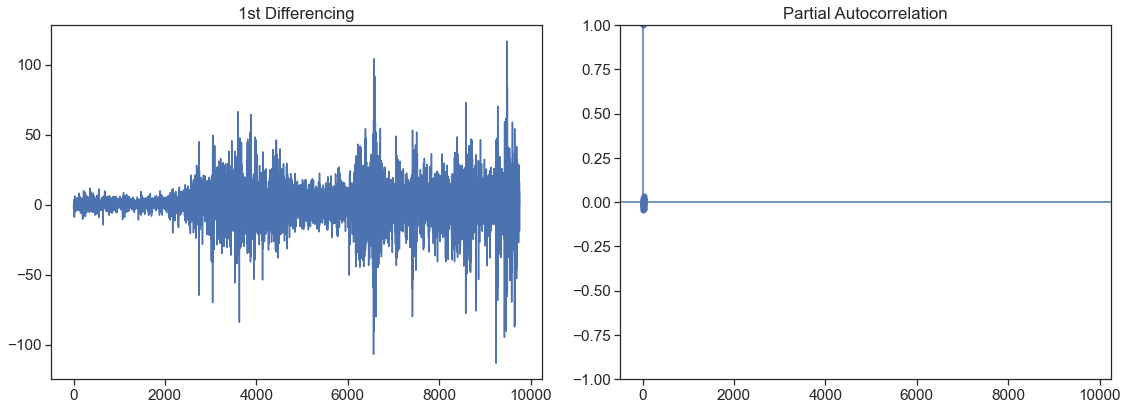

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(16,6)})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y.diff().dropna(), ax=axes[1])

plt.show()

Lag 1 seems to be the most significant.

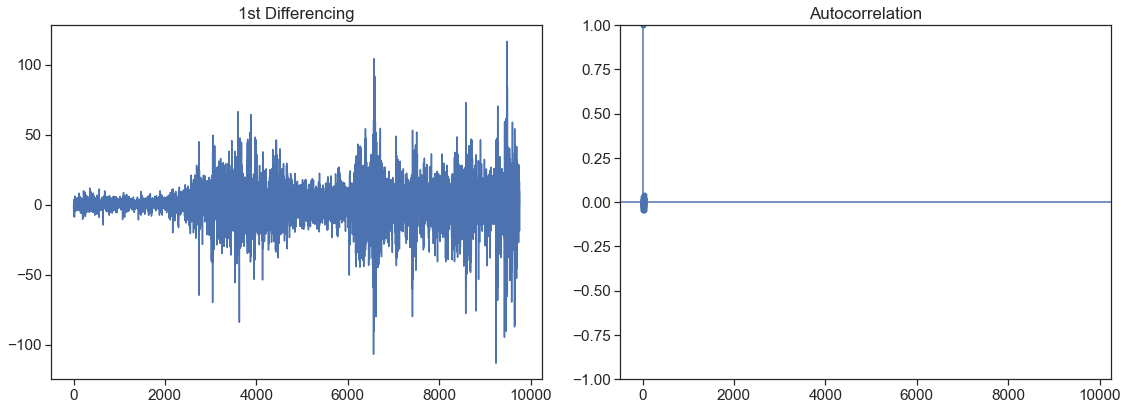

In [ ]:
# ACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y.diff().dropna(), ax=axes[1])

plt.show()

Lag 1 again, seems to be the most significant.

In [ ]:
## Fitting ARIMA model with recommended p,d,q values
model=ARIMA(y_train,order=(1,1,2))
model_fit=model.fit()
model_fit.summary()

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 9217
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -35326.110
Date:                Thu, 13 Oct 2022   AIC                          70660.219
Time:                        11:29:48   BIC                          70688.734
Sample:                             0   HQIC                         70669.910
                               - 9217                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8113      0.052     15.497      0.000       0.709       0.914
ma.L1         -0.8676      0.052    -16.552      0.000      -0.970      -0.765
ma.L2          0.0251      0.008      3.060      0.002       0.009       0.041
sigma2       125.0080      0.798    156.555      0.000     123.443     126.573
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             30413.26
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               9.06   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

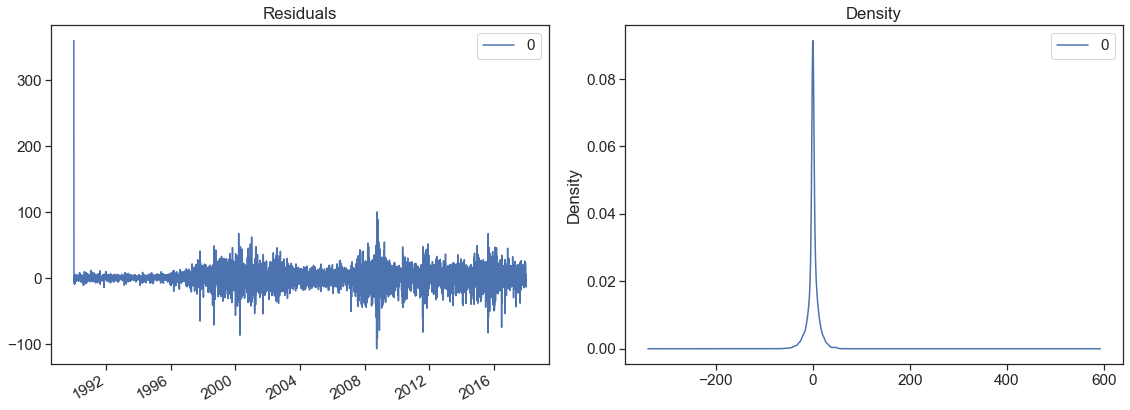

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
fc = model_fit.forecast(540)
fc_series = pd.Series(fc.values, y_test.index)

test_rmse = np.sqrt(mean_squared_error(y_test, fc_series))
test_mape = mean_absolute_percentage_error(y_test, fc_series)

print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}"))

Test RMSE: 217.86
Test MAPE: 0.06


/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


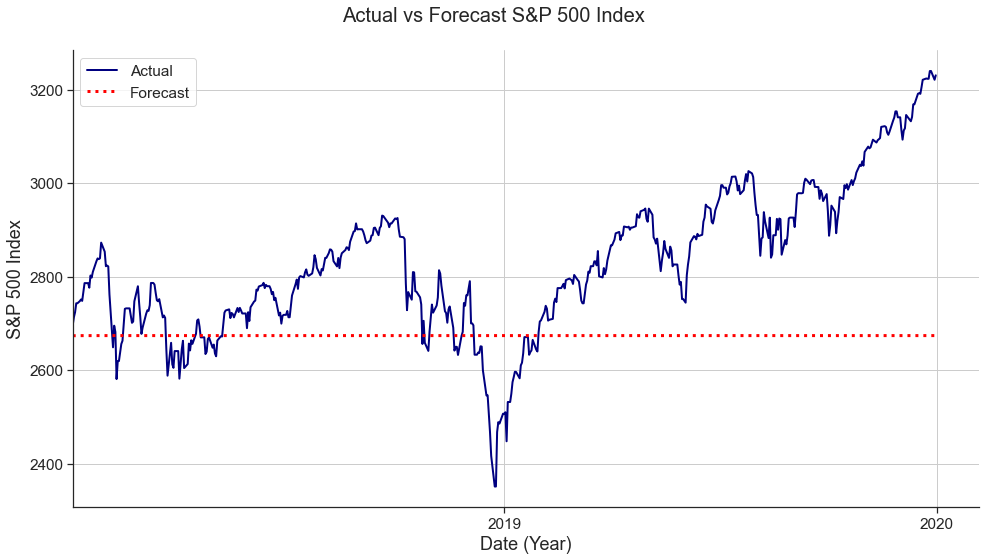

In [ ]:
linegraph(y_test,fc_series, base = 1)

Analysis:
- Using the recommended hyperparameter values, we get basically a flat line.
- Test RMSE = 217.86 & Test MAPE = 0.06 (6% error).
- We should adjust the hyperparameters to see if we can get a better prediction.

### 4.1 Testing ARIMA for 5-Year Data

In [ ]:
## Use only the last 5 years of data - 4.8 years for training and 2 months for forecasting
y = df.close

start_date = "2014-1-1"
end_date = "2019-12-31"

mask = (y.index >= start_date) & (y.index <= end_date)

y = y.loc[mask]
date = y.index

In [ ]:
y.shape

(1639,)

In [ ]:
period = 60
# Create Training and Test
train = y[:(len(y)-period)]
test = y[(len(y)-period):]

model = ARIMA(train, order=(1, 1, 2)) 
fitted = model.fit() 

# Forecast
fc = fitted.forecast(period)

# Make as pandas series
fc_series = pd.Series(fc.values, test.index)

test_rmse = np.sqrt(mean_squared_error(test, fc))
test_mape = mean_absolute_percentage_error(test, fc)  # MAPE

print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}"))


/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test RMSE: 199.07
Test MAPE: 0.06


/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


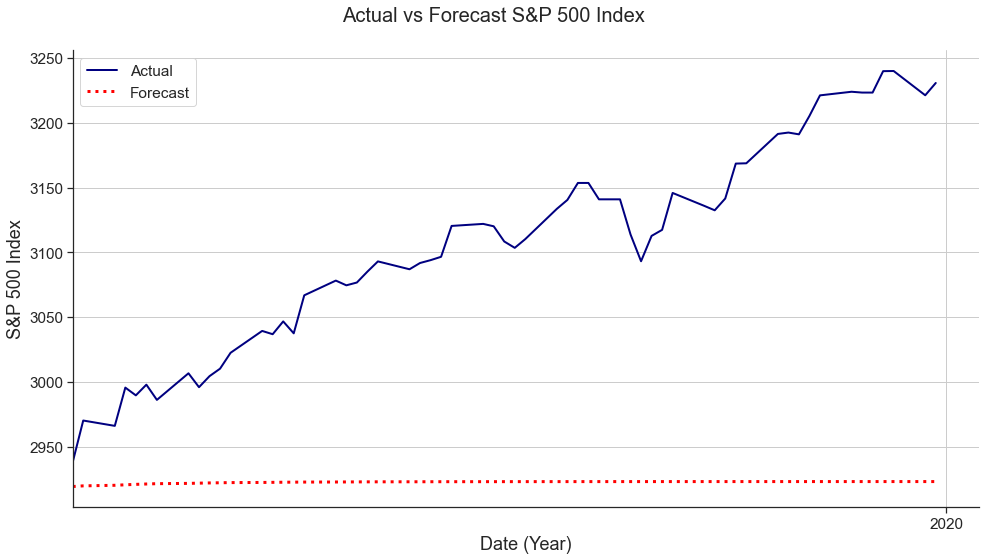

In [ ]:
linegraph(test,fc_series, base = 1)

Analysis:
- It seems the forecast is not very good, possibly because of lack of training data.
- Test RMSE = 199.07, Test MAPE = 0.06 (6% error)

__NOTES__:
ARIMA Pros:
- Good for creating baseline forecasting scores.
- Explainable and easy to interpret

ARIMA Cons:
- Exponential complexity as hyperparameters increase
- If the data is too complex, there is no optimal solution for p and q.
- Requires considerable amount of data. (For example, using three years of historical demand is likely not to be enough (short life-cycle products) for a good forecast.

### 4.2 Testing for the Whole Dataset

In [ ]:
y = df.close

In [ ]:
y.shape

(9757,)

In [ ]:
# Create Training and Test
train = y[:9217]
test = y[9217:]

model = ARIMA(train, order=(12, 2, 2))  ## From trial and error, this gives the best forecast
fitted = model.fit() 

# Forecast
fc = fitted.forecast(540)

# Make as pandas series
fc_series = pd.Series(fc.values, test.index)

test_rmse = np.sqrt(mean_squared_error(test, fc))
test_mape = mean_absolute_percentage_error(test, fc)  # MAPE

print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}"))


/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test RMSE: 129.83
Test MAPE: 0.04


/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


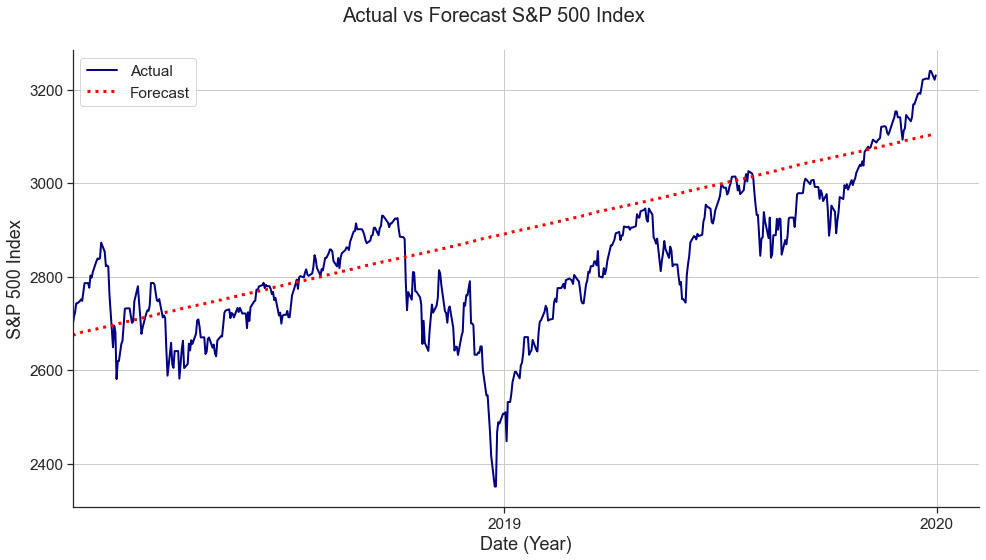

In [ ]:
linegraph(test,fc_series, base = 1)

Analysis:
- Similar to AR model, the forecast is basically a straight line showing the general trend of future prices.
- This give test RMSE of 129.83 and MAPE of 0.04. This is slightly worse than our baseline scores for AR model. This is probably because our p and q values were not optimised (the data is too complex), so just a simple AR can do a better job.

## 5. Linear Regression Forecasting

We will start to look into using more complex machine learning algorithms to see if we can do better than our baseline AR model.

### 5.1 Univariate Regression

We will first start with univariate regression, using only the stock price and excluding all other features.

In [26]:
## We are making 30 day forecast based on the previous 14 days of data.
## The dataframe will consists of lagging features and future steps
steps=30
lags=14
n = int(540/steps - 1)
i_list = [0] + list(np.linspace(steps, 540-steps, num=n))
i_list = [int(i) for i in i_list]

# Two weeks of lag features
y = df.close.copy()
X = make_lags(y, "X", lags=lags).fillna(0.0)

In [ ]:
# One-month forecast
y = make_multistep_target(df.close, steps=steps).dropna()

In [ ]:
# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [ ]:
X

X_lag_1      X_lag_2      X_lag_3      X_lag_4      X_lag_5  \
1990-01-01     0.000000     0.000000     0.000000     0.000000     0.000000   
1990-01-02   359.690002     0.000000     0.000000     0.000000     0.000000   
1990-01-03   359.690002   359.690002     0.000000     0.000000     0.000000   
1990-01-04   358.760010   359.690002   359.690002     0.000000     0.000000   
1990-01-05   355.670013   358.760010   359.690002   359.690002     0.000000   
...                 ...          ...          ...          ...          ...   
2019-11-15  3096.629883  3094.040039  3091.840088  3087.010010  3093.080078   
2019-11-18  3120.459961  3096.629883  3094.040039  3091.840088  3087.010010   
2019-11-19  3122.030029  3120.459961  3096.629883  3094.040039  3091.840088   
2019-11-20  3120.179932  3122.030029  3120.459961  3096.629883  3094.040039   
2019-11-21  3108.459961  3120.179932  3122.030029  3120.459961  3096.629883   

                X_lag_6      X_lag_7      X_lag_8      X_lag_9     X_lag_10  \
1990-01-01     0.000000     0.000000     0.000000     0.000000     0.000000   
1990-01-02     0.000000     0.000000     0.000000     0.000000     0.000000   
1990-01-03     0.000000     0.000000     0.000000     0.000000     0.000000   
1990-01-04     0.000000     0.000000     0.000000     0.000000     0.000000   
1990-01-05     0.000000     0.000000     0.000000     0.000000     0.000000   
...                 ...          ...          ...          ...          ...   
2019-11-15  3085.179932  3076.780029  3074.620117  3078.270020  3066.909912   
2019-11-18  3093.080078  3085.179932  3076.780029  3074.620117  3078.270020   
2019-11-19  3087.010010  3093.080078  3085.179932  3076.780029  3074.620117   
2019-11-20  3091.840088  3087.010010  3093.080078  3085.179932  3076.780029   
2019-11-21  3094.040039  3091.840088  3087.010010  3093.080078  3085.179932   

               X_lag_11     X_lag_12     X_lag_13     X_lag_14  
1990-01-01     0.000000     0.000000     0.000000     0.000000  
1990-01-02     0.000000     0.000000     0.000000     0.000000  
1990-01-03     0.000000     0.000000     0.000000     0.000000  
1990-01-04     0.000000     0.000000     0.000000     0.000000  
1990-01-05     0.000000     0.000000     0.000000     0.000000  
...                 ...          ...          ...          ...  
2019-11-15  3037.560059  3046.770020  3036.889893  3039.419922  
2019-11-18  3066.909912  3037.560059  3046.770020  3036.889893  
2019-11-19  3078.270020  3066.909912  3037.560059  3046.770020  
2019-11-20  3074.620117  3078.270020  3066.909912  3037.560059  
2019-11-21  3076.780029  3074.620117  3078.270020  3066.909912  

[9728 rows x 14 columns]

In [ ]:
y

y_step_1     y_step_2     y_step_3     y_step_4     y_step_5  \
1990-01-01   359.690002   359.690002   358.760010   355.670013   352.200012   
1990-01-02   359.690002   358.760010   355.670013   352.200012   352.200012   
1990-01-03   358.760010   355.670013   352.200012   352.200012   352.200012   
1990-01-04   355.670013   352.200012   352.200012   352.200012   353.790009   
1990-01-05   352.200012   352.200012   352.200012   353.790009   349.619995   
...                 ...          ...          ...          ...          ...   
2019-11-15  3120.459961  3122.030029  3120.179932  3108.459961  3103.540039   
2019-11-18  3122.030029  3120.179932  3108.459961  3103.540039  3110.290039   
2019-11-19  3120.179932  3108.459961  3103.540039  3110.290039  3133.639893   
2019-11-20  3108.459961  3103.540039  3110.290039  3133.639893  3140.520020   
2019-11-21  3103.540039  3110.290039  3133.639893  3140.520020  3153.629883   

               y_step_6     y_step_7     y_step_8     y_step_9    y_step_10  \
1990-01-01   352.200012   352.200012   353.790009   349.619995   347.309998   
1990-01-02   352.200012   353.790009   349.619995   347.309998   348.529999   
1990-01-03   353.790009   349.619995   347.309998   348.529999   339.929993   
1990-01-04   349.619995   347.309998   348.529999   339.929993   339.929993   
1990-01-05   347.309998   348.529999   339.929993   339.929993   339.929993   
...                 ...          ...          ...          ...          ...   
2019-11-15  3110.290039  3133.639893  3140.520020  3153.629883  3153.629883   
2019-11-18  3133.639893  3140.520020  3153.629883  3153.629883  3140.979980   
2019-11-19  3140.520020  3153.629883  3153.629883  3140.979980  3140.979980   
2019-11-20  3153.629883  3153.629883  3140.979980  3140.979980  3113.870117   
2019-11-21  3153.629883  3140.979980  3140.979980  3113.870117  3093.199951   

            ...    y_step_21    y_step_22    y_step_23    y_step_24  \
1990-01-01  ...   339.149994   330.380005   331.609985   330.260010   
1990-01-02  ...   330.380005   331.609985   330.260010   326.079987   
1990-01-03  ...   331.609985   330.260010   326.079987   325.799988   
1990-01-04  ...   330.260010   326.079987   325.799988   325.799988   
1990-01-05  ...   326.079987   325.799988   325.799988   325.200012   
...         ...          ...          ...          ...          ...   
2019-11-15  ...  3168.570068  3168.800049  3191.449951  3192.520020   
2019-11-18  ...  3168.800049  3191.449951  3192.520020  3191.139893   
2019-11-19  ...  3191.449951  3192.520020  3191.139893  3205.370117   
2019-11-20  ...  3192.520020  3191.139893  3205.370117  3221.219971   
2019-11-21  ...  3191.139893  3205.370117  3221.219971  3224.010010   

              y_step_25    y_step_26    y_step_27    y_step_28    y_step_29  \
1990-01-01   326.079987   325.799988   325.799988   325.200012   322.980011   
1990-01-02   325.799988   325.799988   325.200012   322.980011   329.079987   
1990-01-03   325.799988   325.200012   322.980011   329.079987   328.790009   
1990-01-04   325.200012   322.980011   329.079987   328.790009   330.920013   
1990-01-05   322.980011   329.079987   328.790009   330.920013   330.920013   
...                 ...          ...          ...          ...          ...   
2019-11-15  3191.139893  3205.370117  3221.219971  3224.010010  3223.379883   
2019-11-18  3205.370117  3221.219971  3224.010010  3223.379883  3223.379883   
2019-11-19  3221.219971  3224.010010  3223.379883  3223.379883  3239.909912   
2019-11-20  3224.010010  3223.379883  3223.379883  3239.909912  3240.020020   
2019-11-21  3223.379883  3223.379883  3239.909912  3240.020020  3221.290039   

              y_step_30  
1990-01-01   329.079987  
1990-01-02   328.790009  
1990-01-03   330.920013  
1990-01-04   330.920013  
1990-01-05   330.920013  
...                 ...  
2019-11-15  3223.379883  
2019-11-18  3239.909912  
2019-11-19  3240.020020  
2019-11-20  3221.290039  
2019-11-21  3230.780029  

[9

In [ ]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=540, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_mape = mean_absolute_percentage_error(y_test, y_pred)  # MAPE
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))


Train RMSE: 36.90
Test RMSE: 85.25
Test MAPE: 0.02



Analysis:
- The model is less over-fitted compared to AR model based on the difference in train and test RMSE.
- The test RMSE = 85.25 and Test MAPE = 0.02, which is much better than our base AR model.

In [ ]:
## Getting a snapshot of the first 30 dyas forecast
y_slice = df.close.copy()
i = 0
start_date = y_test.index[i]
end_date = y_test.index[steps+i-1]

mask = (df.close.index >= start_date) & (df.close.index <= end_date)

y_slice = y_slice.loc[mask]

pred_value = y_pred.iloc[1].values
pred_value = pd.Series(pred_value, index = y_slice.index)

In [ ]:
pred_value = y_pred.iloc[0].values

In [ ]:
pred_value = pd.Series(pred_value, index = y_slice.index)

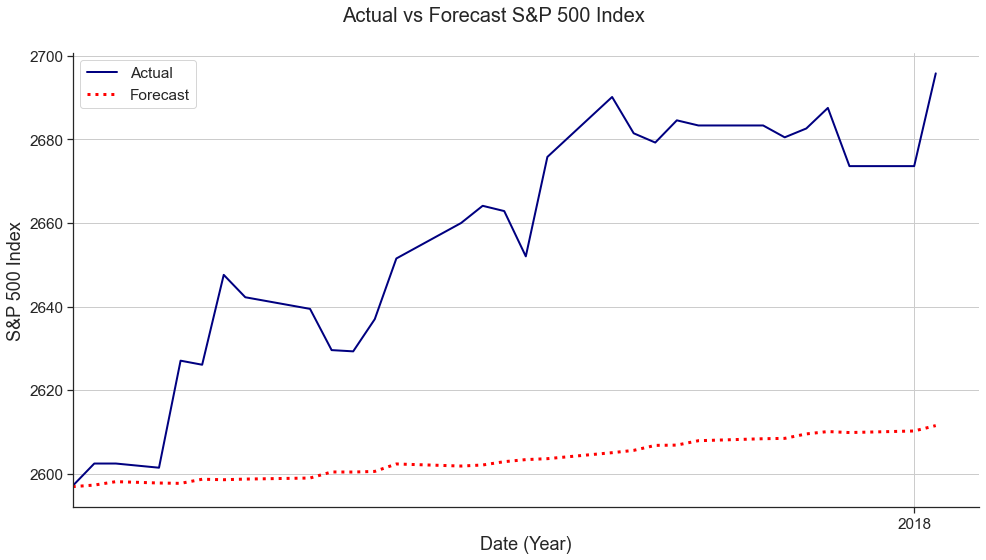

In [ ]:
linegraph(y_slice, pred_value, base=1)

In [ ]:
test_rmse = mean_squared_error(y_slice, pred_value, squared=False)
test_mape = mean_absolute_percentage_error(y_slice, pred_value)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 57.39
Test MAPE: 0.02



Analysis:
- 30 day forecast seems to do quite well, with MAPE of 0.02.
- However, this requires some context. 2% error in investment could result in a significant amount of loss. For example, if a person sold their single stock on day 1 for 2600 dollars, based on this forecast, they would've lost ~100 dollars in potential earning.

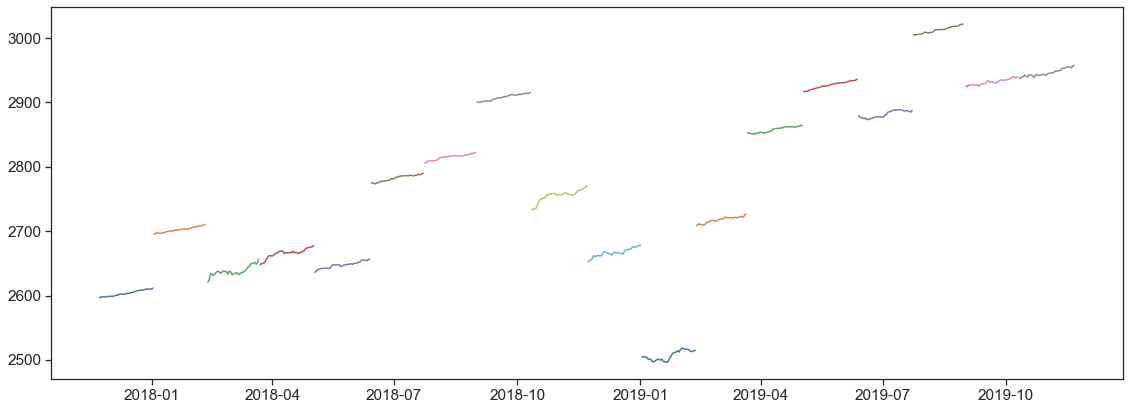

In [ ]:
## Getting a series of 30-day forecasts
y_actual = []
y_fore = []

for i in i_list: 
    y_slice = df.close.copy()
    start_date = y_test.index[i]
    end_date = y_test.index[steps+i-1]

    mask = (df.close.index >= start_date) & (df.close.index <= end_date)

    y_slice = y_slice.loc[mask]

    pred_value = y_pred.iloc[i].values
    pred_value = pd.Series(pred_value, index = y_slice.index)
    
    plt.plot(pred_value)
    y_actual.append(y_slice)
    y_fore.append(pred_value)

y_actual = pd.concat(y_actual)
y_fore = pd.concat(y_fore)
linear_y_fore = y_fore

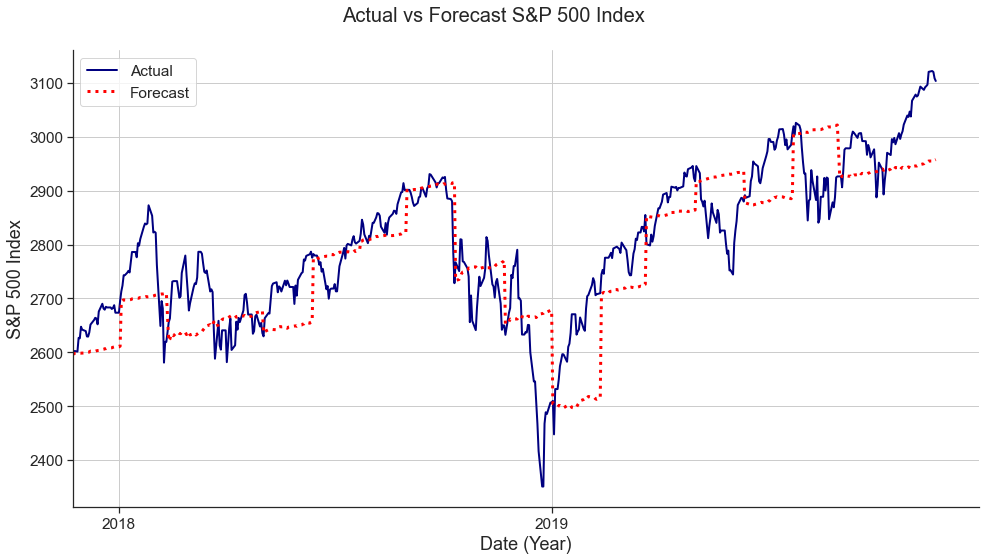

In [ ]:
linegraph(y_actual, y_fore, base=1)

In [ ]:
test_rmse = mean_squared_error(y_actual, y_fore, squared=False)
test_mape = mean_absolute_percentage_error(y_actual, y_fore)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 85.61
Test MAPE: 0.02



Analysis:
- The forecast is getting some general trends correct, but for some of the forecasts, there is a potential where an investor may lose significant amount of money.

### 5.2 Multivariate Regression

Here, we will include all other features to see if it improves our model prediction.

In [ ]:
# 14 days of lag features
columns = df.columns
X_list = []

for col in columns:
    X = make_lags(df[col], col, lags = lags).fillna(0.0)
    X_list.append(X)

X = pd.concat(X_list, axis = 1)

# Eight-week forecast
y = make_multistep_target(df.close, steps=steps).dropna()
X = pd.concat(X_list, axis = 1)

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [ ]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=540, shuffle=False)

## Train the model using linear regression
model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [ ]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_mape = mean_absolute_percentage_error(y_test, y_pred)  # MAPE
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Train RMSE: 34.07
Test RMSE: 82.66
Test MAPE: 0.02



Analysis:
- The test RMSE = 82.66 and Test MAPE = 0.02, which is a slight improvement over univariate model.

In [ ]:
y_slice = df.close.copy()
i = 0
start_date = y_test.index[i]
end_date = y_test.index[steps+i-1]

mask = (df.close.index >= start_date) & (df.close.index <= end_date)

y_slice = y_slice.loc[mask]

pred_value = y_pred.iloc[1].values
pred_value = pd.Series(pred_value, index = y_slice.index)

In [ ]:
pred_value = y_pred.iloc[1].values

In [ ]:
pred_value = pd.Series(pred_value, index = y_slice.index)

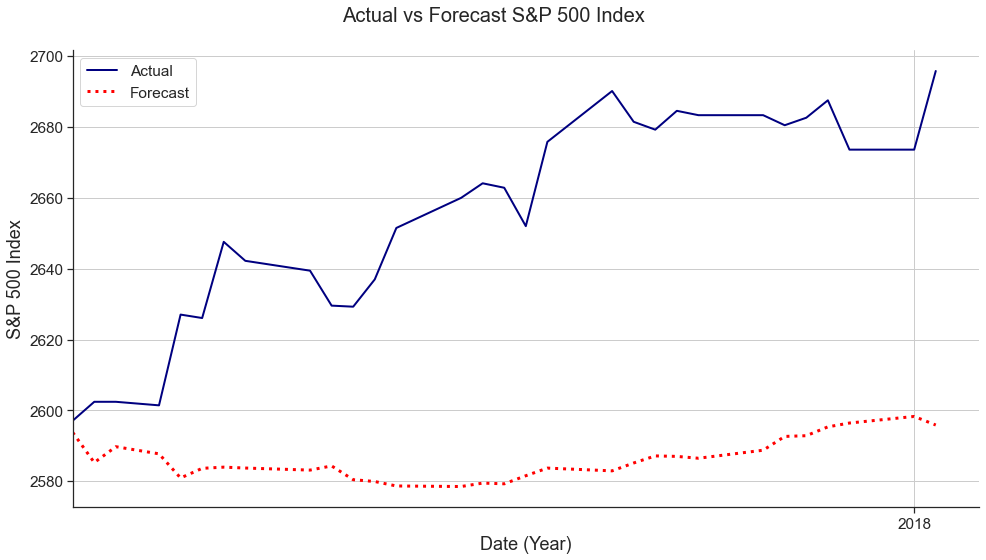

In [ ]:
linegraph(y_slice, pred_value, base=1)

In [ ]:
test_rmse = mean_squared_error(y_slice, pred_value, squared=False)
test_mape = mean_absolute_percentage_error(y_slice, pred_value)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 74.27
Test MAPE: 0.03



Analysis:
- Again, a slight improvement over the univariate model, but not a significant improvement.   

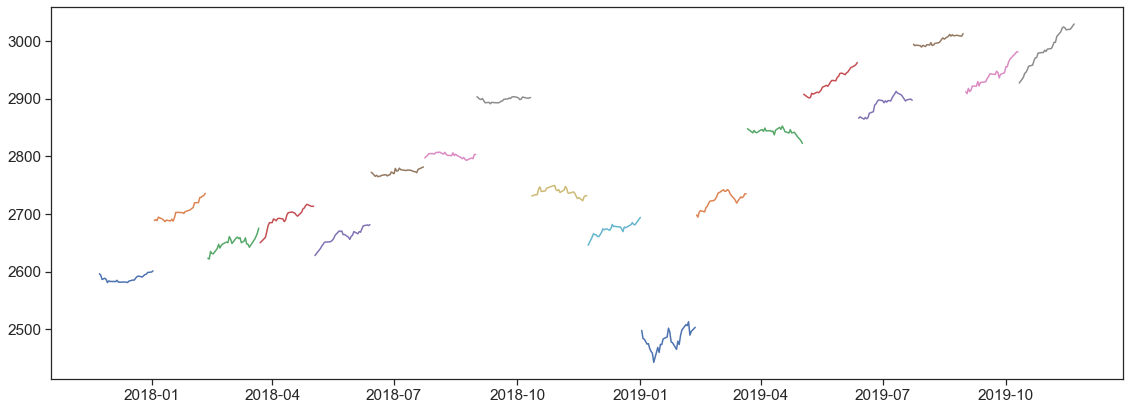

In [ ]:
y_actual = []
y_fore = []

for i in i_list: 
    y_slice = df.close.copy()
    start_date = y_test.index[i]
    end_date = y_test.index[steps+i-1]

    mask = (df.close.index >= start_date) & (df.close.index <= end_date)

    y_slice = y_slice.loc[mask]

    pred_value = y_pred.iloc[i].values
    pred_value = pd.Series(pred_value, index = y_slice.index)
    
    plt.plot(pred_value)
    y_actual.append(y_slice)
    y_fore.append(pred_value)

y_actual = pd.concat(y_actual)
y_fore = pd.concat(y_fore)


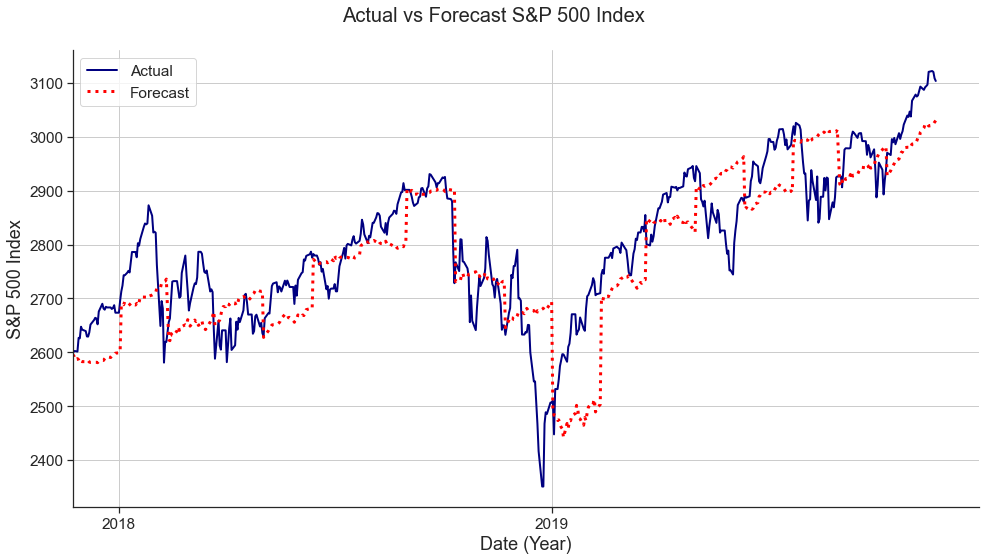

In [ ]:
linegraph(y_actual, y_fore, base=1)

In [ ]:
test_rmse = mean_squared_error(y_actual, y_fore, squared=False)
test_mape = mean_absolute_percentage_error(y_actual, y_fore)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 85.23
Test MAPE: 0.02



Analysis:
- We begin to see slight local changes in each forecast, unlike in univariate model, where each forecast was a simple straight line.

## 6. Non-Linear Regression Forecasting

### Helper Functions for Streamlining the preparation of data and machine learning
<br><br>
From here on, we will use helper functions to prepare our data and automate the machine learning with minimal user input.

In [13]:
## Helper Function for 
def prepare_data(steps=30, lags=14, test_size=540):
    ## Prepare training and testing datasets
    n = int(test_size/steps - 1)
    i_list = [0] + list(np.linspace(steps, test_size-steps, num=n))
    i_list = [int(i) for i in i_list]

    # Two weeks of lag features
    y = df.close.copy()

    columns = df.columns
    X_list = []

    for col in columns:
        X = make_lags(df[col], col, lags = lags).fillna(0.0)
        X_list.append(X)

    X = pd.concat(X_list, axis = 1)

    y = make_multistep_target(df.close, steps=steps).dropna()

    y, X = y.align(X, join='inner', axis=0)

    # Create splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    return X_train, X_test, y_train, y_test

In [14]:
## Helper Function for Scaling the Datasets
def scale_data(X_train, X_test, y_train, y_test):
    ## Call StandardScaler for for both X and y datasets
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    ## Get column names
    X_columns = list(X_train.columns)
    y_columns = list(y_train.columns)

    ## Scale the datasets
    X_train_scaled = X_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)
    
    X_test_scaled = X_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test)
    
    ## Turn the scaled data into dataframe
    X_train = pd.DataFrame(X_train_scaled, columns = X_columns, index = X_train.index)
    y_train = pd.DataFrame(y_train_scaled, columns = y_columns, index = y_train.index)
    
    X_test = pd.DataFrame(X_test_scaled, columns = X_columns, index = X_test.index)
    y_test = pd.DataFrame(y_test_scaled, columns = y_columns, index = y_test.index)
    
    return X_train, X_test, y_train, y_test, X_scaler, y_scaler


In [15]:
def get_unscaled_data(y_pred, y_test, y_scaler):
#     y_scaler = StandardScaler()
#     y_train_scaled = y_scaler.fit_transform(y_train)
    y_columns = list(y_test.columns)
    unscaled = y_scaler.inverse_transform(y_pred)
    y_pred = pd.DataFrame(unscaled, columns = y_columns, index = y_test.index)
    
    return y_pred

In [16]:
def get_snapshot(y_pred, y_test, steps = 30, i = 0):
    steps = 30
    y_slice = df.close.copy()
    i = 0
    start_date = y_test.index[i]
    end_date = y_test.index[steps+i-1]
    
    mask = (df.close.index >= start_date) & (df.close.index <= end_date)
    
    y_slice = y_slice.loc[mask]
    
    pred_value = y_pred.iloc[1].values
    pred_value = pd.Series(pred_value, index = y_slice.index)
    
    linegraph(y_slice, pred_value, base=1)
    print(start_date, end_date)
    test_rmse = mean_squared_error(y_slice, pred_value, squared=False)
    test_mape = mean_absolute_percentage_error(y_slice, pred_value)  # MAPE
    print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))
    
    return test_rmse

In [17]:
def get_forecast(y_pred, y_test, graph=True):
    y_actual = []
    y_fore = []
    
    for i in i_list: 
        y_slice = df.close.copy()
        start_date = y_test.index[i]
        end_date = y_test.index[steps+i-1]
    
        mask = (df.close.index >= start_date) & (df.close.index <= end_date)
    
        y_slice = y_slice.loc[mask]
    
        pred_value = y_pred.iloc[i].values
        pred_value = pd.Series(pred_value, index = y_slice.index)
        
        y_actual.append(y_slice)
        y_fore.append(pred_value)
    
    y_actual = pd.concat(y_actual)
    y_fore = pd.concat(y_fore)
    
    if graph == True:
      linegraph(y_actual, y_fore, base=1)
    else:
      pass
    
    test_rmse = mean_squared_error(y_actual, y_fore, squared=False)
    print((f"Test RMSE: {test_rmse:.2f}"))
    
    return y_actual, y_fore, test_rmse

### 6.1 SVM Regressor

In [ ]:
## Use the Helper Functions to Get the Datasets
X_train, X_test, y_train, y_test = prepare_data()
X_train, X_test, y_train, y_test, X_scaler, y_scaler = scale_data(X_train, X_test, y_train, y_test)

In [ ]:
# param_grid = {'estimator__C': [0.001, 0.005, 0.01],
#               'estimator__kernel': ["rbf", 'linear']}

# grid = GridSearchCV(model, 
#                     scoring="neg_mean_squared_error",
#                     return_train_score=True, 
#                     n_jobs=-1, 
#                     param_grid=param_grid)

In [ ]:
# grid.fit(X_train, y_train)

In [ ]:
# print("Best estimator: ", grid.best_estimator_)
# print("Best parameters: ", grid.best_params_)
# print("Best mean cross-validation score: ", round(grid.best_score_, 3)) 

In [ ]:
# y_pred = grid.predict(X_test)

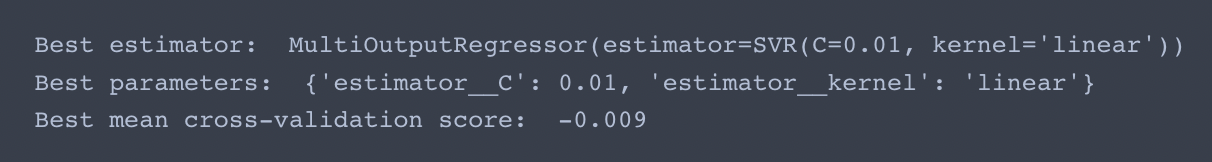

After running gridsearch, the best hyperparameters for svr model are:
- C = 0.01
- Kernel = linear

In [ ]:
svr = SVR(C = 0.01, kernel="linear")
model = MultiOutputRegressor(svr)

In [ ]:
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR(C=0.01, kernel='linear'))

In [ ]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

In [ ]:
y_train_unscaled = get_unscaled_data(y_train, y_train, y_scaler)
y_fit = get_unscaled_data(y_fit, y_train, y_scaler)
y_pred = get_unscaled_data(y_pred, y_test, y_scaler)

In [ ]:
train_rmse = mean_squared_error(y_train_unscaled, y_fit, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n"))

Train RMSE: 35.95



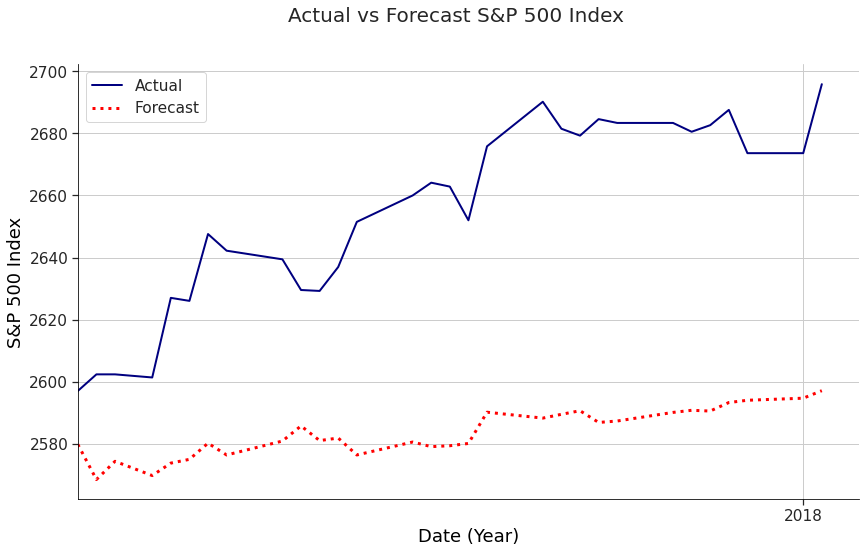

2017-11-23 00:00:00 2018-01-02 00:00:00
Test RMSE: 74.94
Test MAPE: 0.03



In [ ]:
snapshot_rmse = get_snapshot(y_pred, y_test)

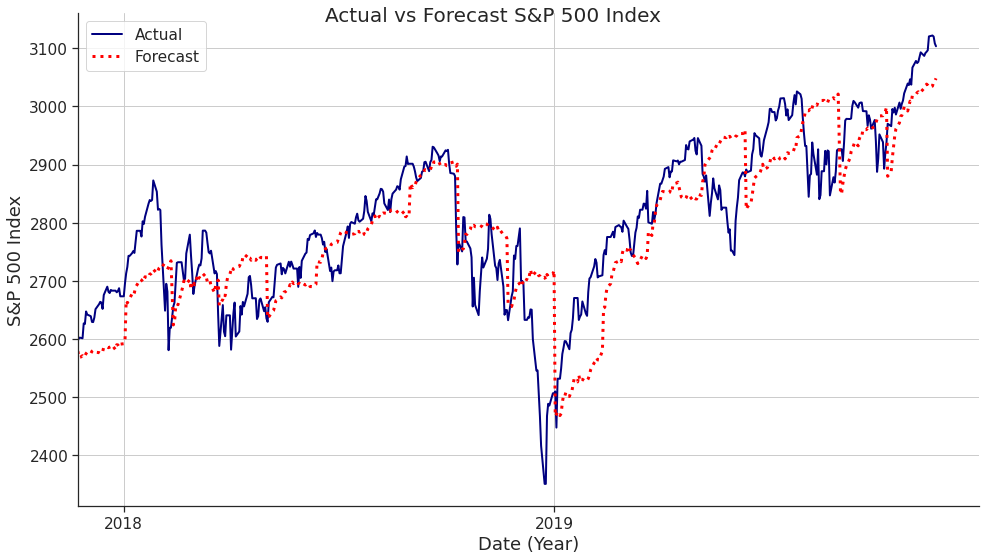

Test RMSE: 82.55


In [ ]:
y_actual, svr_y_fore, svr_rmse = get_forecast(y_pred, y_test)

In [ ]:
test_rmse = mean_squared_error(y_actual, svr_y_fore, squared=False)
test_mape = mean_absolute_percentage_error(y_actual, svr_y_fore)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 82.55
Test MAPE: 0.02



Analysis:
- The training RMSE is 35.95, and the test RMSE is 82.55, with MAPE of 0.02.
- The SVR performed slightly better than the linear regression model, but not by much

### 6.2 Random Forest Regressor

In [18]:
## Use the Helper Functions to Get the Datasets
X_train, X_test, y_train, y_test = prepare_data()
X_train, X_test, y_train, y_test, X_scaler, y_scaler = scale_data(X_train, X_test, y_train, y_test)

In [ ]:
# param_grid = {'estimator__n_estimators': [5,20,50,100,200,500],
#               'estimator__max_depth': [10,20,30]}

# grid = GridSearchCV(model, 
#                     scoring="neg_mean_squared_error",
#                     return_train_score=True, 
#                     n_jobs = -1, 
#                     cv = 2,
#                     param_grid=param_grid,
#                     verbose=4)

In [ ]:
# grid.fit(X_train, y_train)

In [ ]:
# print("Best estimator: ", grid.best_estimator_)
# print("Best parameters: ", grid.best_params_)
# print("Best mean cross-validation score: ", round(grid.best_score_, 3)) 

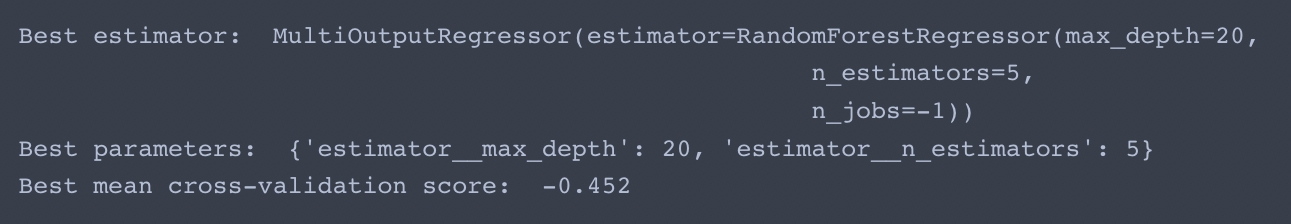

Best hyperparameters to use are: n_estimators = 5, max_depth = 20

In [19]:
rfr = RandomForestRegressor(n_estimators=5,
                            max_depth=20)
model = MultiOutputRegressor(rfr)

In [20]:
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=20,
                                                     n_estimators=5))

In [21]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

In [22]:
y_train_unscaled = get_unscaled_data(y_train, y_train, y_scaler)
y_fit = get_unscaled_data(y_fit, y_train, y_scaler)
y_pred = get_unscaled_data(y_pred, y_test, y_scaler)

In [23]:
train_rmse = mean_squared_error(y_train_unscaled, y_fit, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n"))

Train RMSE: 7.94



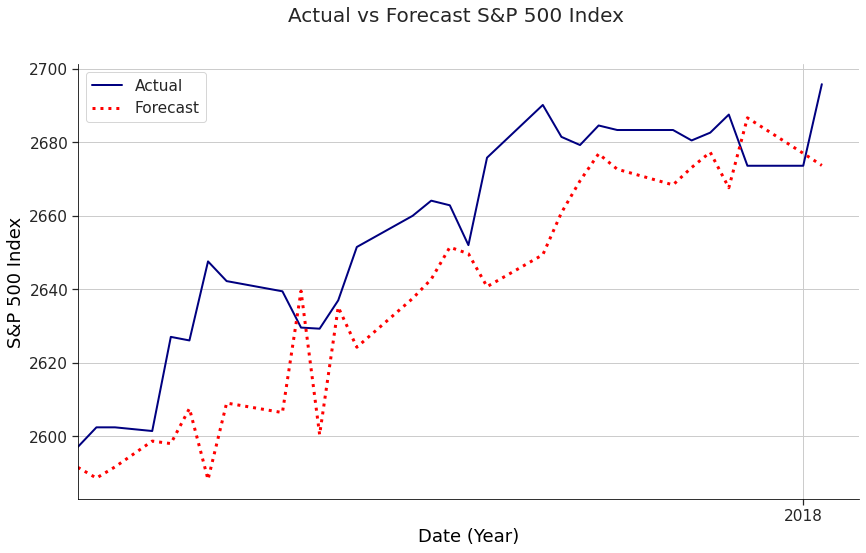

2017-11-23 00:00:00 2018-01-02 00:00:00
Test RMSE: 22.35
Test MAPE: 0.01



In [24]:
snapshot_rmse = get_snapshot(y_pred, y_test)

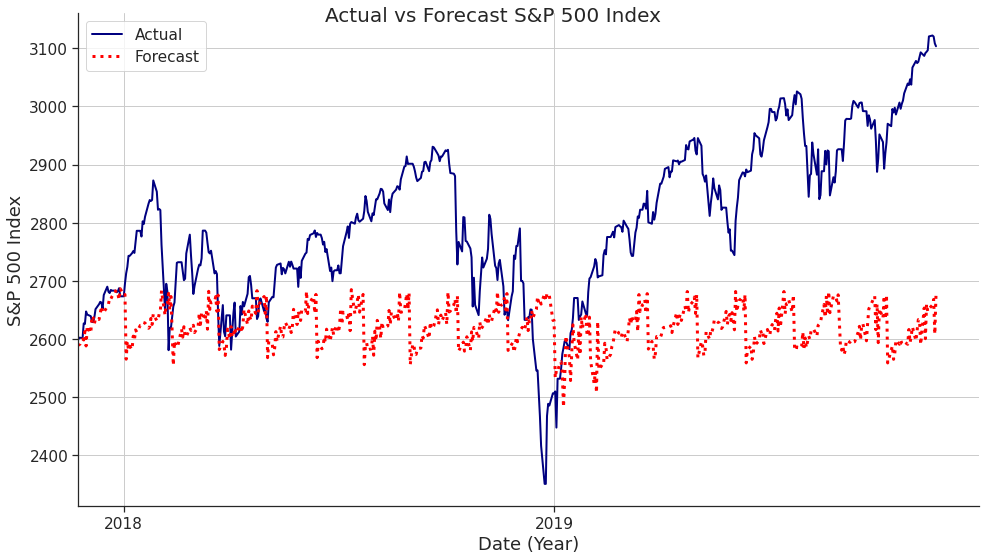

Test RMSE: 225.56


In [27]:
y_actual, rfr_y_fore, rfr_rmse = get_forecast(y_pred, y_test)

In [28]:
test_rmse = mean_squared_error(y_actual, rfr_y_fore, squared=False)
test_mape = mean_absolute_percentage_error(y_actual, rfr_y_fore)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 225.56
Test MAPE: 0.07



Analysis:
- The train RMSE is 7.99 and test RMSE is 229.42, with MAPE of 0.07.
- In terms of long-term forecasting, this model has performed very poorly compared to others.
- However, if we just focus on the first 30 days of forecast, this model so far gave the best result: RMSE = 18.53, and MAPE = 0.01.
- The model has learnt very well from the training dataset to make very accurate short-term forecast, but fails to perform well in the long-term without re-training.
- To make this model effective, we would need to retrain the model after every forecast.

### 6.3 XGBoost Regressor

Important Hyperparameters for XGBoost:
- eta (learning rate): step size shrinkage in update to prevent overfitting. Typical final values: 0.01-0.2.
- max_depth: used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample. Increasing this value will make the model more complex and more likely to overfit. Typical values: 3-10.

In [29]:
## Use the Helper Functions to Get the Datasets
X_train, X_test, y_train, y_test = prepare_data()
X_train, X_test, y_train, y_test, X_scaler, y_scaler = scale_data(X_train, X_test, y_train, y_test)

In [ ]:
# param_grid = {'estimator__eta': [0.05],
#               'estimator__max_depth': [5],
#               'estimator__n_estimators' : [100, 200]}
# #               'estimator__subsample': [0.5, 1]
# #               'estimator__gamma': [0, 1, 2],
# grid = GridSearchCV(model, 
#                     scoring="neg_mean_squared_error",
#                     return_train_score=True, 
#                     n_jobs = -1, 
#                     cv = 2,
#                     param_grid=param_grid,
#                     verbose=4)

In [ ]:
# grid.fit(X_train, y_train)

In [ ]:
# print("Best estimator: ", grid.best_estimator_)
# print("Best parameters: ", grid.best_params_)
# print("Best mean cross-validation score: ", round(grid.best_score_, 3)) 

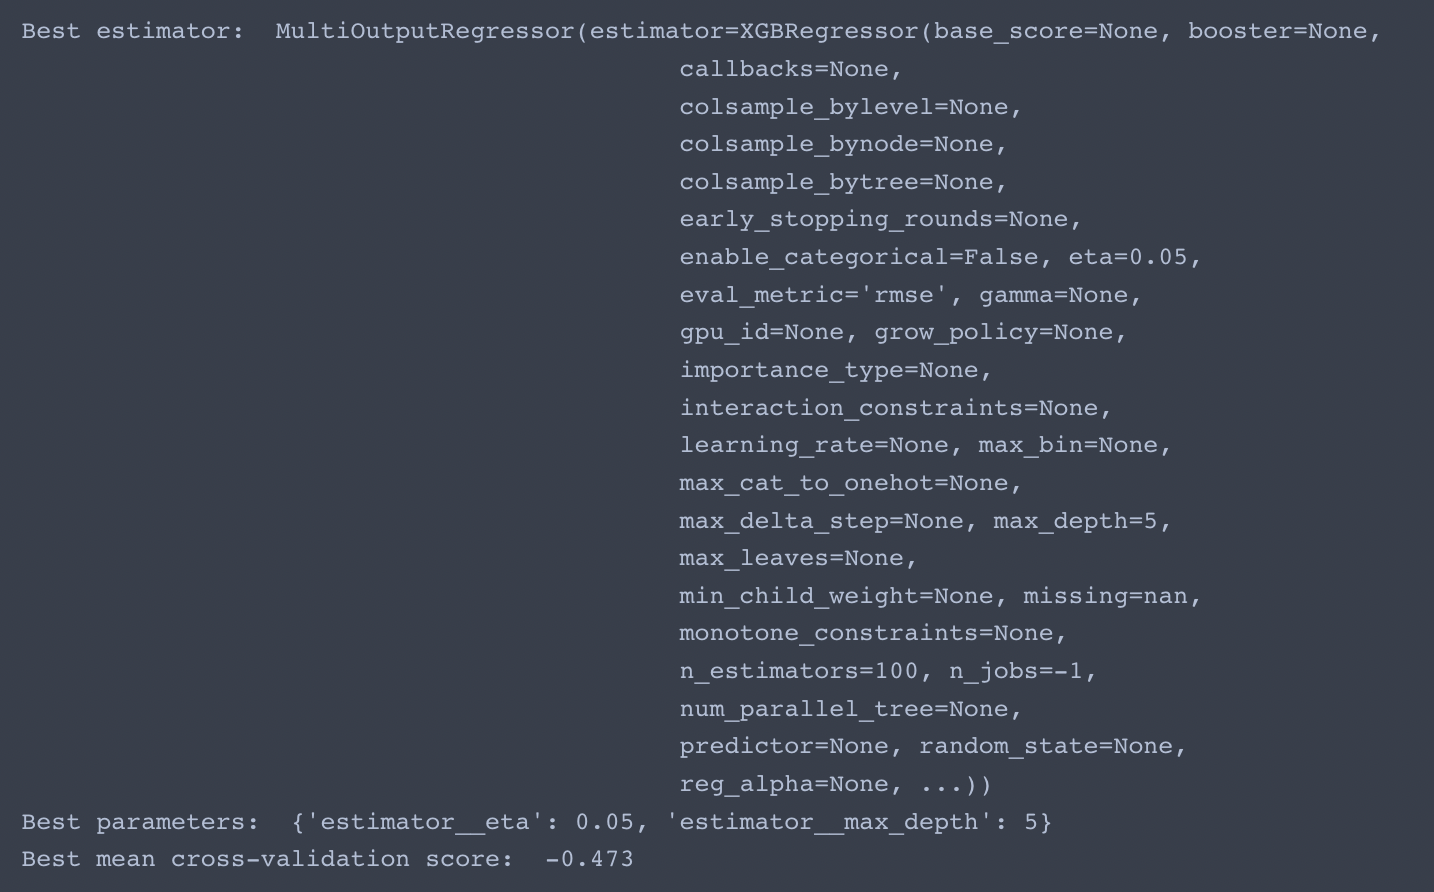

In [30]:
xgb = XGBRegressor(eta = 0.05,
                   max_depth = 5,
                   n_estimators=100,
                   objective='reg:squarederror')

model = MultiOutputRegressor(xgb)

In [31]:
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(eta=0.05, max_depth=5,
                                            objective='reg:squarederror'))

In [32]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

In [33]:
y_train_unscaled = get_unscaled_data(y_train, y_train, y_scaler)
y_fit = get_unscaled_data(y_fit, y_train, y_scaler)
y_pred = get_unscaled_data(y_pred, y_test, y_scaler)

In [34]:
train_rmse = mean_squared_error(y_train_unscaled, y_fit, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n"))

Train RMSE: 13.71



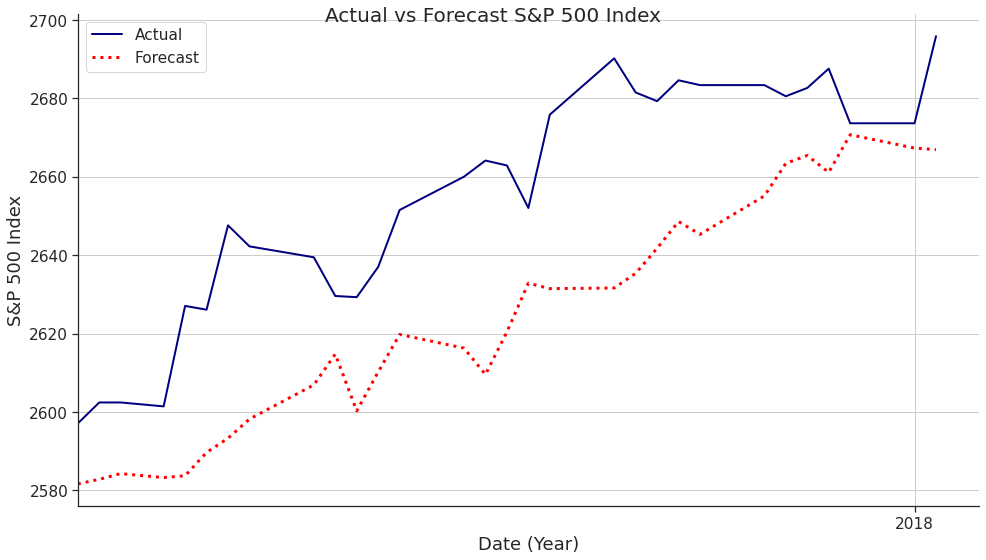

2017-11-23 00:00:00 2018-01-02 00:00:00
Test RMSE: 34.12
Test MAPE: 0.01



In [35]:
snapshot_rmse = get_snapshot(y_pred, y_test)

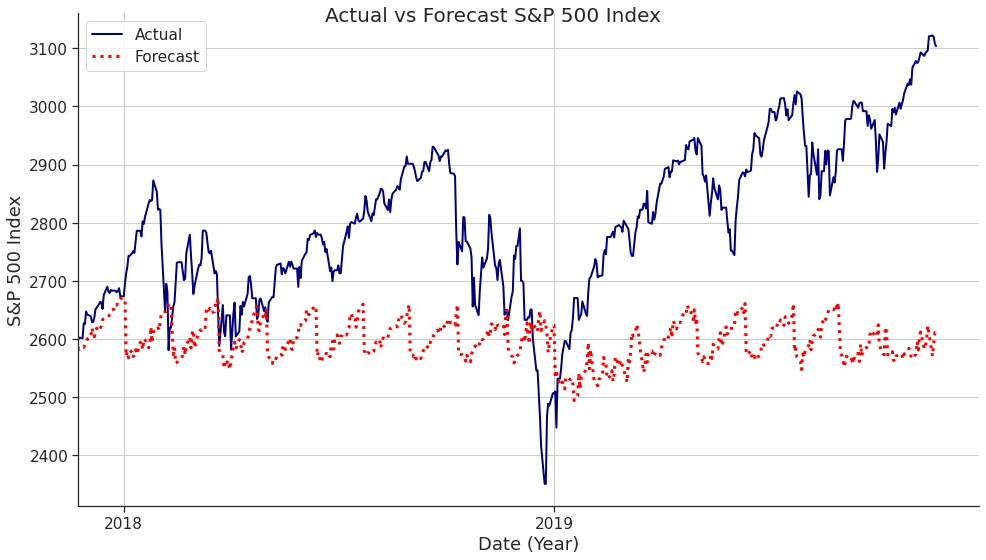

Test RMSE: 244.78


In [36]:
y_actual, xgb_y_fore, xgb_rmse = get_forecast(y_pred, y_test)

In [37]:
test_rmse = mean_squared_error(y_actual, xgb_y_fore, squared=False)
test_mape = mean_absolute_percentage_error(y_actual, xgb_y_fore)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 244.78
Test MAPE: 0.07



Let's try this again just using the default parameter values..

In [38]:
## Use the Helper Functions to Get the Datasets
X_train, X_test, y_train, y_test = prepare_data()
X_train, X_test, y_train, y_test, X_scaler, y_scaler = scale_data(X_train, X_test, y_train, y_test)

In [39]:
xgb = XGBRegressor()
model = MultiOutputRegressor(xgb)

In [40]:
model.fit(X_train, y_train)

[04:13:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:13:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:13:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:13:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:14:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:14:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:14:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:14:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

MultiOutputRegressor(estimator=XGBRegressor())

In [41]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

In [42]:
y_train_unscaled = get_unscaled_data(y_train, y_train, y_scaler)
y_fit = get_unscaled_data(y_fit, y_train, y_scaler)
y_pred = get_unscaled_data(y_pred, y_test, y_scaler)

In [43]:
train_rmse = mean_squared_error(y_train_unscaled, y_fit, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n"))

Train RMSE: 23.13



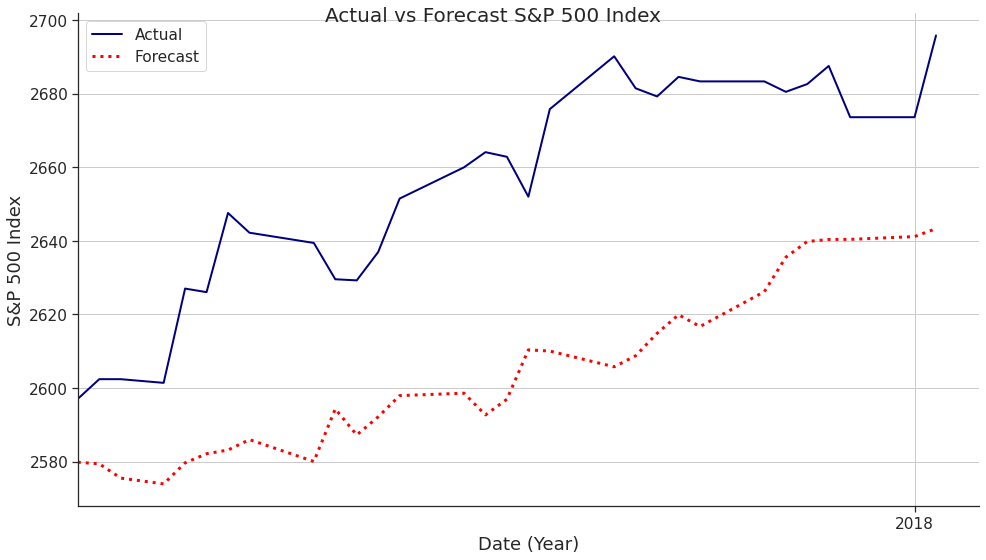

2017-11-23 00:00:00 2018-01-02 00:00:00
Test RMSE: 52.87
Test MAPE: 0.02



In [44]:
snapshot_rmse = get_snapshot(y_pred, y_test)

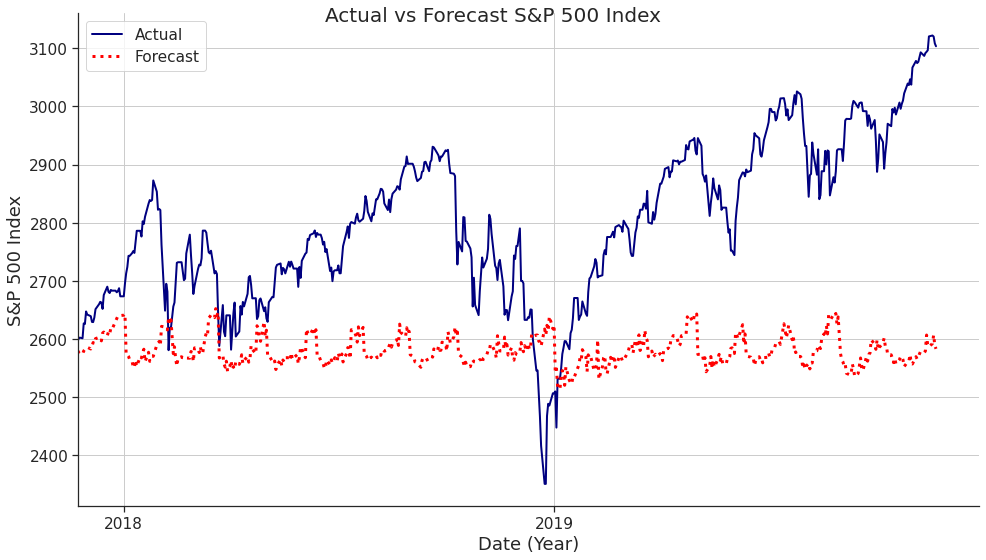

Test RMSE: 258.71


In [45]:
y_actual, xgb1_y_fore, xgb1_rmse = get_forecast(y_pred, y_test)

In [46]:
test_rmse = mean_squared_error(y_actual, xgb1_y_fore, squared=False)
test_mape = mean_absolute_percentage_error(y_actual, xgb1_y_fore)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 258.71
Test MAPE: 0.08



Analysis:
- The default model performed better than the GridSearch model.
- The train RMSE is 5.34, with test RMSE of 238.03 and MAPE of 0.07.
- As we have seen with Random Forest model, XGB model also suffers from decreasing inaccuracy over time.
- It has done quite well for the first 30 day forecast (slightly worse than Random Forest).

## 7. Hybrid Models

We will combine two different models (linear and nonlinear regression) to improve our prediction. We will use the linear model to remove the trend from the series and the second nonlinear model will learn the residual resulting from the first model.

### 7.1 Linear Regression First Model

In [ ]:
## Use the Helper Functions to Get the Datasets
X_train, X_test, y_train, y_test = prepare_data()
X_train, X_test, y_train, y_test, X_scaler, y_scaler = scale_data(X_train, X_test, y_train, y_test)

We will first train the linear regression model just using the target variable (y_train), and get the residual (y_train - y_fit). We will use this residual to train XGB model, and then finally combine the two predictions to get the final prediction.

In [ ]:
## Split the training dataset for model 1 and model 2
X_train_1 = X_train.iloc[:,-14:]
X_train_2 = X_train.iloc[:,:-14]

X_test_1 = X_test.iloc[:,-14:]
X_test_2 = X_test.iloc[:,:-14]

In [ ]:
model1 = LinearRegression()
model1.fit(X_train_1, y_train)

y_fit_1 = pd.DataFrame(model1.predict(X_train_1), index=X_train.index, columns=y_train.columns)
y_pred_1 = pd.DataFrame(model1.predict(X_test_1), index=X_test.index, columns=y_train.columns)


In [ ]:
residual_train = y_train - y_fit
residual_test = y_test - y_pred

In [ ]:
residual_train

y_step_1  y_step_2  y_step_3  y_step_4  y_step_5  y_step_6  \
1990-01-01  0.690381  0.689982  0.687806  0.681496  0.674471  0.674144   
1990-01-02  0.035255  0.037537  0.040183  0.053076  0.072110  0.078447   
1990-01-03  0.003846  0.006743  0.020075  0.040152  0.047642  0.042224   
1990-01-04  0.003136  0.016422  0.036468  0.044184  0.038688  0.049981   
1990-01-05  0.013009  0.033079  0.040864  0.035437  0.046764  0.052691   
...              ...       ...       ...       ...       ...       ...   
2017-11-16  0.038142  0.024118  0.029164  0.058865  0.052982  0.051259   
2017-11-17 -0.012319 -0.006883  0.023469  0.018493  0.018230  0.027581   
2017-11-20  0.005308  0.035577  0.030405  0.029820  0.038819  0.036474   
2017-11-21  0.031188  0.026006  0.025429  0.034651  0.032359  0.030072   
2017-11-22 -0.003244 -0.003598  0.006045  0.004628  0.003286  0.052862   

            y_step_7  y_step_8  y_step_9  y_step_10  ...  y_step_21  \
1990-01-01  0.673823  0.676551  0.668251   0.663521  ...   0.644610   
1990-01-02  0.072725  0.084291  0.088960   0.086311  ...   0.028243   
1990-01-03  0.053573  0.059252  0.057071   0.049468  ...  -0.001909   
1990-01-04  0.055845  0.053960  0.046450   0.046101  ...  -0.017470   
1990-01-05  0.050623  0.043177  0.042878   0.043544  ...  -0.017802   
...              ...       ...       ...        ...  ...        ...   
2017-11-16  0.060081  0.058686  0.055373   0.104318  ...   0.162188   
2017-11-17  0.025393  0.022843  0.072244   0.068916  ...   0.107939   
2017-11-20  0.034202  0.083319  0.079825   0.119889  ...   0.163752   
2017-11-21  0.079316  0.076090  0.116257   0.105123  ...   0.185342   
2017-11-22  0.049247  0.090285  0.079554   0.073722  ...   0.141491   

            y_step_22  y_step_23  y_step_24  y_step_25  y_step_26  y_step_27  \
1990-01-01   0.627585   0.629637   0.626758   0.618495   0.617653   0.617372   
1990-01-02   0.028438   0.016515   0.020262   0.018456   0.035979   0.025932   
1990-01-03  -0.013930  -0.010639  -0.011806   0.005687  -0.003526  -0.001719   
1990-01-04  -0.014415  -0.015519   0.002191  -0.006861  -0.005356   0.008470   
1990-01-05  -0.018872  -0.001215  -0.010247  -0.008769   0.005235   0.012016   
...               ...        ...        ...        ...        ...        ...   
2017-11-16   0.140654   0.184835   0.211166   0.193447   0.187240   0.196009   
2017-11-17   0.152439   0.178078   0.160773   0.154216   0.164658   0.159916   
2017-11-20   0.189355   0.172240   0.165513   0.176021   0.170823   0.169953   
2017-11-21   0.168050   0.161324   0.172017   0.166909   0.165915   0.159209   
2017-11-22   0.134719   0.144985   0.140389   0.139312   0.133481   0.136044   

            y_step_28  y_step_29  y_step_30  
1990-01-01   0.615936   0.611416   0.622724  
1990-01-02   0.028083   0.041400   0.048206  
1990-01-03   0.011839   0.018719   0.024839  
1990-01-04   0.015379   0.021365   0.037206  
1990-01-05   0.018094   0.033989   0.027566  
...               ...        ...        ...  
2017-11-16   0.192261   0.190776   0.183730  
2017-11-17   0.158776   0.152089   0.155152  
2017-11-20   0.163108   0.166080   0.173662  
2017-11-21   0.162208   0.169707   0.143586  
2017-11-22   0.143825   0.117808   0.117259  

[9188 rows x 30 columns]

In [ ]:
residual_test

y_step_1     y_step_2     y_step_3     y_step_4     y_step_5  \
2017-11-23 -2594.713261 -2597.594236 -2585.695972 -2595.349332 -2603.772181   
2017-11-24 -2599.070702 -2597.513740 -2584.526189 -2590.635707 -2606.672186   
2017-11-25 -2604.265577 -2600.877424 -2590.789541 -2594.084908 -2602.336132   
2017-11-27 -2599.360868 -2592.567829 -2570.597802 -2595.073552 -2591.840327   
2017-11-28 -2590.850637 -2594.108577 -2572.793431 -2598.014359 -2596.993080   
...                 ...          ...          ...          ...          ...   
2019-11-15 -3092.956928 -3096.418326 -3104.144367 -3100.796555 -3091.018625   
2019-11-18 -3116.092456 -3128.567247 -3135.822450 -3120.201826 -3111.860264   
2019-11-19 -3114.415953 -3128.757168 -3128.499190 -3094.763307 -3118.422026   
2019-11-20 -3108.412665 -3122.770324 -3115.011582 -3096.700352 -3114.954796   
2019-11-21 -3098.258025 -3102.587504 -3116.061353 -3087.597455 -3104.413189   

               y_step_6     y_step_7     y_step_8     y_step_9    y_step_10  \
2017-11-23 -2609.287628 -2605.158818 -2626.987633 -2636.466796 -2626.837920   
2017-11-24 -2605.478186 -2587.581926 -2615.916592 -2636.235047 -2631.965676   
2017-11-25 -2596.196124 -2587.723411 -2606.842098 -2635.340034 -2597.950363   
2017-11-27 -2590.688510 -2595.425743 -2620.413777 -2610.000681 -2587.668596   
2017-11-28 -2585.940464 -2597.292227 -2622.897442 -2608.173366 -2595.355273   
...                 ...          ...          ...          ...          ...   
2019-11-15 -3105.063060 -3120.121944 -3117.980173 -3112.955880 -3132.806862   
2019-11-18 -3125.869125 -3128.967559 -3138.171271 -3131.901267 -3157.404387   
2019-11-19 -3121.548666 -3134.325805 -3139.811601 -3135.373785 -3160.471737   
2019-11-20 -3102.340574 -3128.420225 -3129.172870 -3119.809575 -3153.652125   
2019-11-21 -3098.802783 -3115.965079 -3113.260144 -3108.125647 -3134.150288   

            ...    y_step_21    y_step_22    y_step_23    y_step_24  \
2017-11-23  ... -2675.792501 -2674.339169 -2672.771986 -2665.101268   
2017-11-24  ... -2656.258296 -2671.023505 -2669.319355 -2661.917923   
2017-11-25  ... -2669.433437 -2685.021595 -2674.626978 -2654.724261   
2017-11-27  ... -2669.835043 -2667.781932 -2676.690180 -2655.692143   
2017-11-28  ... -2653.923745 -2683.469313 -2674.324638 -2665.822474   
...         ...          ...          ...          ...          ...   
2019-11-15  ... -3137.159648 -3131.509661 -3103.771961 -3120.544757   
2019-11-18  ... -3153.354176 -3161.587867 -3129.308231 -3144.566213   
2019-11-19  ... -3156.868399 -3173.246637 -3133.056395 -3144.187558   
2019-11-20  ... -3156.842363 -3176.871965 -3136.085557 -3144.275837   
2019-11-21  ... -3149.310721 -3172.687123 -3138.338651 -3134.617991   

              y_step_25    y_step_26    y_step_27    y_step_28    y_step_29  \
2017-11-23 -2679.641737 -2680.359237 -2669.593100 -2667.402913 -2670.122161   
2017-11-24 -2673.728062 -2683.332020 -2676.154475 -2667.533068 -2681.132725   
2017-11-25 -2671.777062 -2669.730919 -2662.784147 -2668.659065 -2678.719582   
2017-11-27 -2660.894906 -2668.856155 -2675.665322 -2682.821891 -2670.832365   
2017-11-28 -2666.301346 -2673.616136 -2678.841689 -2690.257795 -2676.395445   
...                 ...          ...          ...          ...          ...   
2019-11-15 -3171.430532 -3115.330632 -3127.983342 -3158.782147 -3168.370084   
2019-11-18 -3189.136763 -3138.149814 -3154.730714 -3194.875239 -3190.798296   
2019-11-19 -3197.457341 -3142.620073 -3157.299727 -3187.913104 -3194.923756   
2019-11-20 -3194.227644 -3139.625211 -3164.364190 -3199.284169 -3188.098563   
2019-11-21 -3199.831571 -3128.788449 -3146.777004 -3179.310016 -3180.328333   

              y_step_30  
2017-11-23 -2671.012651  
2017-11-24 -2678.723213  
2017-11-25 -2682.399485  
2017-11-27 -2668.989650  
2017-11-28 -2662.332254  
...                 ...  
2019-11-15 -3133.534434  
2019-11-18 -3152.043230  
2019-11-19 -3163.398737  
2019-11-20 -3159.142351  
2019-11-21 -3141.097857  

[5

#### 7.1.1 Combine with XGB

In [ ]:
model2 = MultiOutputRegressor(XGBRegressor())
model2.fit(X_train_2, residual_train)

y_fit_2 = pd.DataFrame(model2.predict(X_train_2), index=X_train_2.index, columns=y_train.columns)
y_pred_2 = pd.DataFrame(model2.predict(X_test_2), index=X_test_2.index, columns=y_train.columns)

In [ ]:
y_fit_2

y_step_1  y_step_2  y_step_3  y_step_4  y_step_5  y_step_6  \
1990-01-01  0.688561  0.689988  0.689314  0.679090  0.678577  0.675788   
1990-01-02  0.033151  0.036222  0.039253  0.053128  0.071895  0.079246   
1990-01-03  0.003439  0.004489  0.021317  0.040289  0.047731  0.041576   
1990-01-04  0.003168  0.016716  0.032215  0.046577  0.037592  0.050938   
1990-01-05  0.011584  0.034274  0.039825  0.035238  0.046486  0.052422   
...              ...       ...       ...       ...       ...       ...   
2017-11-16  0.034565  0.023546  0.025795  0.054634  0.055552  0.059562   
2017-11-17 -0.011957 -0.001153  0.023462  0.013268  0.017935  0.038945   
2017-11-20  0.004932  0.031760  0.025897  0.035214  0.040865  0.034106   
2017-11-21  0.029504  0.020708  0.024411  0.041862  0.019174  0.031533   
2017-11-22 -0.001870 -0.000350  0.008609  0.001142  0.007831  0.043149   

            y_step_7  y_step_8  y_step_9  y_step_10  ...  y_step_21  \
1990-01-01  0.670332  0.676343  0.668242   0.668186  ...   0.644946   
1990-01-02  0.070242  0.084472  0.088413   0.085116  ...   0.026950   
1990-01-03  0.056266  0.058769  0.058783   0.051343  ...  -0.000272   
1990-01-04  0.053383  0.052161  0.046406   0.049124  ...  -0.012418   
1990-01-05  0.052419  0.042670  0.044015   0.042509  ...  -0.018619   
...              ...       ...       ...        ...  ...        ...   
2017-11-16  0.059010  0.060100  0.058732   0.098710  ...   0.156432   
2017-11-17  0.026599  0.032675  0.067321   0.071634  ...   0.119204   
2017-11-20  0.034704  0.081134  0.085599   0.120165  ...   0.160970   
2017-11-21  0.060338  0.074961  0.105803   0.105864  ...   0.181096   
2017-11-22  0.047859  0.079276  0.079111   0.069164  ...   0.136526   

            y_step_22  y_step_23  y_step_24  y_step_25  y_step_26  y_step_27  \
1990-01-01   0.630105   0.630593   0.626590   0.618928   0.619421   0.618876   
1990-01-02   0.024564   0.018586   0.022446   0.018073   0.038743   0.024519   
1990-01-03  -0.012312  -0.013515  -0.013066   0.002675  -0.006155   0.000700   
1990-01-04  -0.019422  -0.016792   0.002285  -0.006899  -0.006872   0.009399   
1990-01-05  -0.020363   0.001308  -0.011887  -0.012874   0.004000   0.008990   
...               ...        ...        ...        ...        ...        ...   
2017-11-16   0.140068   0.180112   0.201049   0.186802   0.179513   0.195929   
2017-11-17   0.151988   0.167145   0.160497   0.156591   0.163093   0.154883   
2017-11-20   0.183267   0.167726   0.168807   0.172437   0.168632   0.165917   
2017-11-21   0.166828   0.158361   0.174578   0.163386   0.167748   0.162425   
2017-11-22   0.137145   0.145891   0.134283   0.140566   0.138901   0.130404   

            y_step_28  y_step_29  y_step_30  
1990-01-01   0.614839   0.612817   0.621483  
1990-01-02   0.028606   0.042132   0.048597  
1990-01-03   0.012395   0.017929   0.025190  
1990-01-04   0.017154   0.017272   0.031234  
1990-01-05   0.018751   0.034614   0.025533  
...               ...        ...        ...  
2017-11-16   0.187740   0.190567   0.181257  
2017-11-17   0.157067   0.153258   0.146101  
2017-11-20   0.165428   0.166270   0.165680  
2017-11-21   0.153805   0.169052   0.146137  
2017-11-22   0.142933   0.126191   0.119723  

[9188 rows x 30 columns]

In [ ]:
y_pred_2

y_step_1  y_step_2  y_step_3  y_step_4  y_step_5  y_step_6  \
2017-11-23  0.001290  0.006123 -0.018299  0.000851  0.017266  0.025935   
2017-11-24  0.009214  0.004608 -0.019755 -0.007701  0.021091  0.019040   
2017-11-25  0.008180  0.002346 -0.016538 -0.011945  0.004543 -0.007277   
2017-11-27  0.000811 -0.011779 -0.055746 -0.008079 -0.014376 -0.017200   
2017-11-28 -0.014746 -0.010124 -0.050212 -0.002122 -0.004288 -0.027751   
...              ...       ...       ...       ...       ...       ...   
2019-11-15  0.000148  0.006561  0.020590  0.015057 -0.006879  0.018296   
2019-11-18  0.001497  0.024981  0.040416  0.008494 -0.007862  0.020232   
2019-11-19 -0.006248  0.022735  0.020228 -0.044550  0.001977  0.005360   
2019-11-20 -0.013912  0.011772 -0.003064 -0.037321 -0.004609 -0.028252   
2019-11-21 -0.012612 -0.004774  0.021238 -0.035741 -0.004579 -0.015824   

            y_step_7  y_step_8  y_step_9  y_step_10  ...  y_step_21  \
2017-11-23  0.018307  0.059825  0.077468   0.056180  ...   0.137371   
2017-11-24 -0.015452  0.038472  0.074585   0.066478  ...   0.100178   
2017-11-25 -0.024082  0.009969  0.064769  -0.007362  ...   0.114804   
2017-11-27 -0.010546  0.037603  0.017136  -0.028737  ...   0.116123   
2017-11-28 -0.006080  0.042102  0.010682  -0.013439  ...   0.086342   
...              ...       ...       ...        ...  ...        ...   
2019-11-15  0.047919  0.041916  0.031186   0.068609  ...   0.062714   
2019-11-18  0.023658  0.041397  0.029358   0.076456  ...   0.053456   
2019-11-19  0.030297  0.041236  0.031104   0.076649  ...   0.055936   
2019-11-20  0.021982  0.021440  0.000870   0.064028  ...   0.057755   
2019-11-21  0.016546  0.009151 -0.002420   0.046794  ...   0.061307   

            y_step_22  y_step_23  y_step_24  y_step_25  y_step_26  y_step_27  \
2017-11-23   0.134444   0.129389   0.113820   0.141303   0.140594   0.118986   
2017-11-24   0.126149   0.122007   0.107761   0.128279   0.145252   0.132107   
2017-11-25   0.143711   0.123559   0.083753   0.114844   0.111902   0.097656   
2017-11-27   0.111781   0.126953   0.085569   0.096511   0.110454   0.121147   
2017-11-28   0.141343   0.122323   0.106854   0.106219   0.118625   0.129526   
...               ...        ...        ...        ...        ...        ...   
2019-11-15   0.050698  -0.002485   0.029585   0.123849   0.017287   0.040126   
2019-11-18   0.068832   0.006699   0.033814   0.118865   0.021833   0.051550   
2019-11-19   0.086191   0.007682   0.029359   0.131187   0.024367   0.049247   
2019-11-20   0.094431   0.016966   0.032672   0.125236   0.018659   0.067170   
2019-11-21   0.104973   0.040460   0.031159   0.153762   0.017136   0.052068   

            y_step_28  y_step_29  y_step_30  
2017-11-23   0.115177   0.119592   0.118866  
2017-11-24   0.114918   0.138288   0.135178  
2017-11-25   0.106408   0.127115   0.132915  
2017-11-27   0.136284   0.112198   0.106603  
2017-11-28   0.149946   0.121748   0.093696  
...               ...        ...        ...  
2019-11-15   0.097603   0.111925   0.047259  
2019-11-18   0.124441   0.118450   0.043763  
2019-11-19   0.109306   0.121434   0.058495  
2019-11-20   0.132368   0.108301   0.053890  
2019-11-21   0.110997   0.112730   0.036945  

[540 rows x 30 columns]

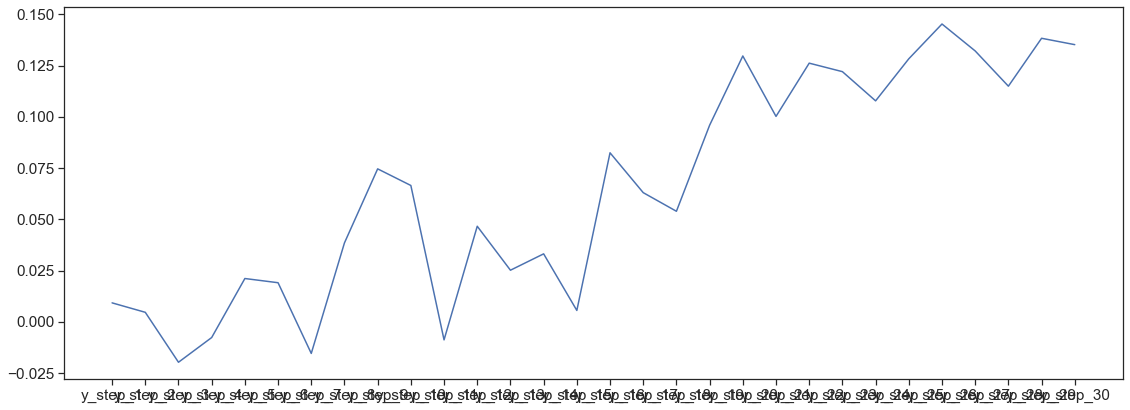

In [ ]:
plt.plot(y_pred_2.iloc[1])

In [ ]:
y_pred = y_pred_1 + y_pred_2

In [ ]:
# y_train_unscaled = get_unscaled_data(y_train, y_train, y_scaler)
# y_fit = get_unscaled_data(y_fit, y_train, y_scaler)
y_pred = get_unscaled_data(y_pred, y_test, y_scaler)

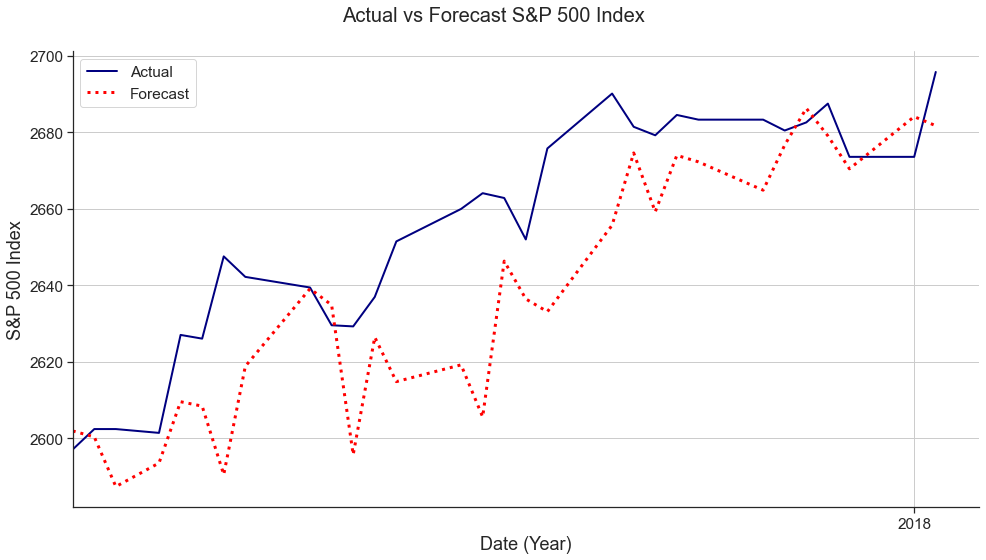

2017-11-23 00:00:00 2018-01-02 00:00:00
Test RMSE: 24.08
Test MAPE: 0.01



In [ ]:
snapshot_rmse = get_snapshot(y_pred, y_test)

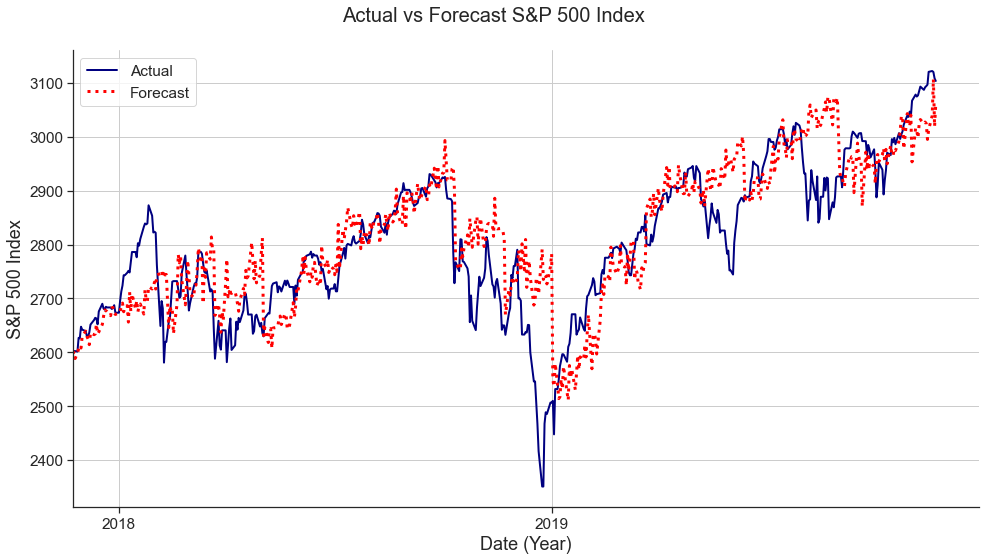

Test RMSE: 83.64


In [ ]:
y_actual, hybrid_y_fore, hybrid_rmse = get_forecast(y_pred, y_test)

In [ ]:
test_rmse = mean_squared_error(y_actual, hybrid_y_fore, squared=False)
test_mape = mean_absolute_percentage_error(y_actual, hybrid_y_fore)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 83.64
Test MAPE: 0.02



Analysis:

#### 7.1.2 Combine with SVM

In [ ]:
svr = SVR(C = 0.01, kernel="linear")
model2 = MultiOutputRegressor(svr)
model2.fit(X_train_2, residual_train)

y_fit_2 = pd.DataFrame(model2.predict(X_train_2), index=X_train_2.index, columns=y_train.columns)
y_pred_2 = pd.DataFrame(model2.predict(X_test_2), index=X_test_2.index, columns=y_train.columns)

In [ ]:
y_pred = y_pred_1 + y_pred_2

In [ ]:
# y_train_unscaled = get_unscaled_data(y_train, y_train, y_scaler)
# y_fit = get_unscaled_data(y_fit, y_train, y_scaler)
y_pred = get_unscaled_data(y_pred, y_test, y_scaler)

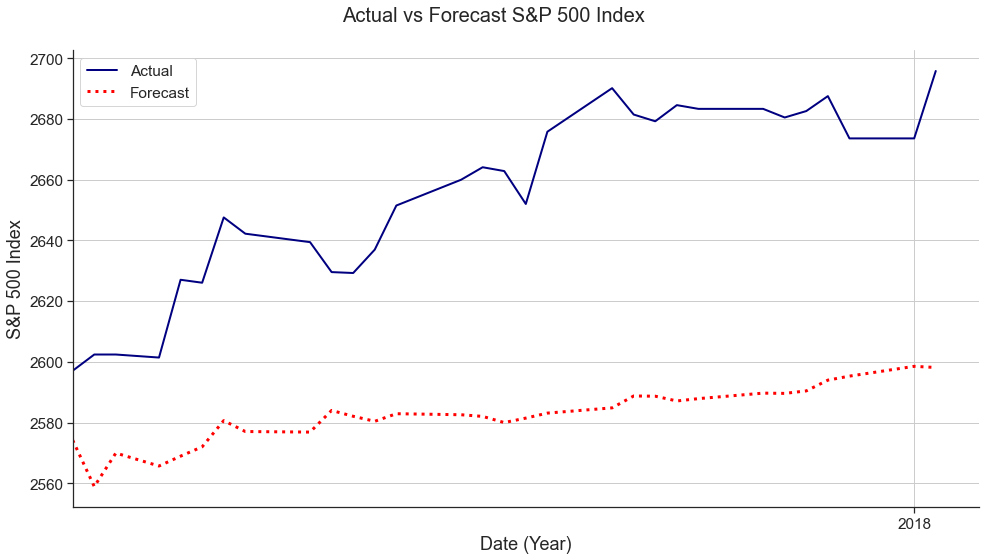

2017-11-23 00:00:00 2018-01-02 00:00:00
Test RMSE: 75.53
Test MAPE: 0.03



In [ ]:
snapshot_rmse = get_snapshot(y_pred, y_test)

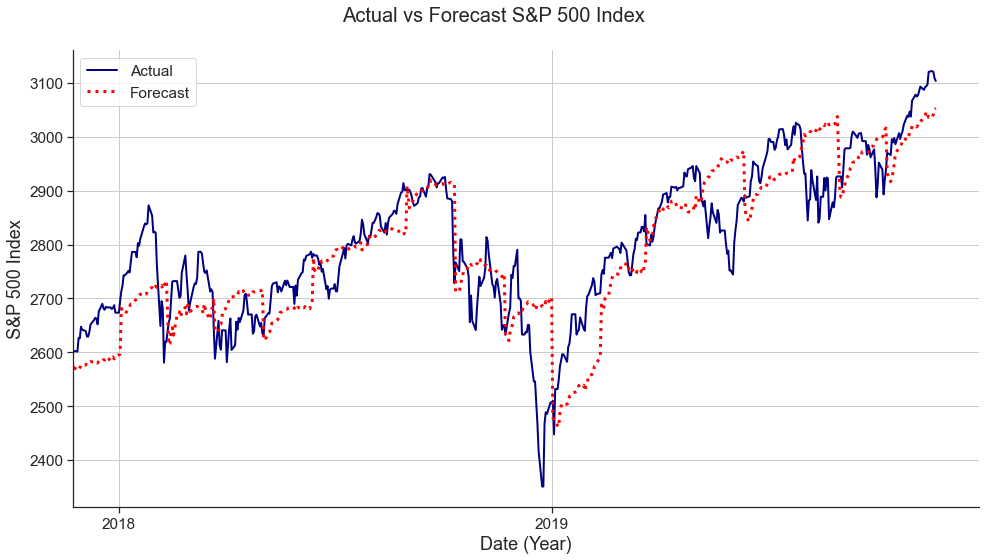

Test RMSE: 78.96


In [ ]:
y_actual, hybrid2_y_fore, hybrid2_rmse = get_forecast(y_pred, y_test)

In [ ]:
test_rmse = mean_squared_error(y_actual, hybrid2_y_fore, squared=False)
test_mape = mean_absolute_percentage_error(y_actual, hybrid2_y_fore)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 78.96
Test MAPE: 0.02



Analysis:

#### 7.1.3 Combine with Random Forest

In [ ]:
rfr = RandomForestRegressor(n_estimators=5,
                            max_depth=20,
                            n_jobs = -1)
model2 = MultiOutputRegressor(rfr)

model2.fit(X_train_2, residual_train)

y_fit_2 = pd.DataFrame(model2.predict(X_train_2), index=X_train_2.index, columns=y_train.columns)
y_pred_2 = pd.DataFrame(model2.predict(X_test_2), index=X_test_2.index, columns=y_train.columns)

In [ ]:
y_pred = y_pred_1 + y_pred_2

In [ ]:
# y_train_unscaled = get_unscaled_data(y_train, y_train, y_scaler)
# y_fit = get_unscaled_data(y_fit, y_train, y_scaler)
y_pred = get_unscaled_data(y_pred, y_test, y_scaler)

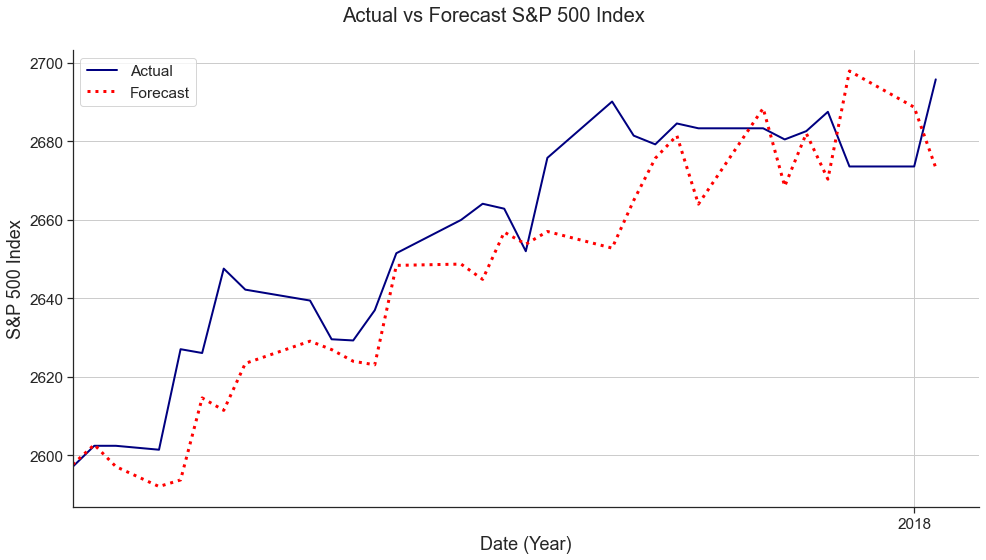

2017-11-23 00:00:00 2018-01-02 00:00:00
Test RMSE: 16.44
Test MAPE: 0.00



In [ ]:
snapshot_rmse = get_snapshot(y_pred, y_test)

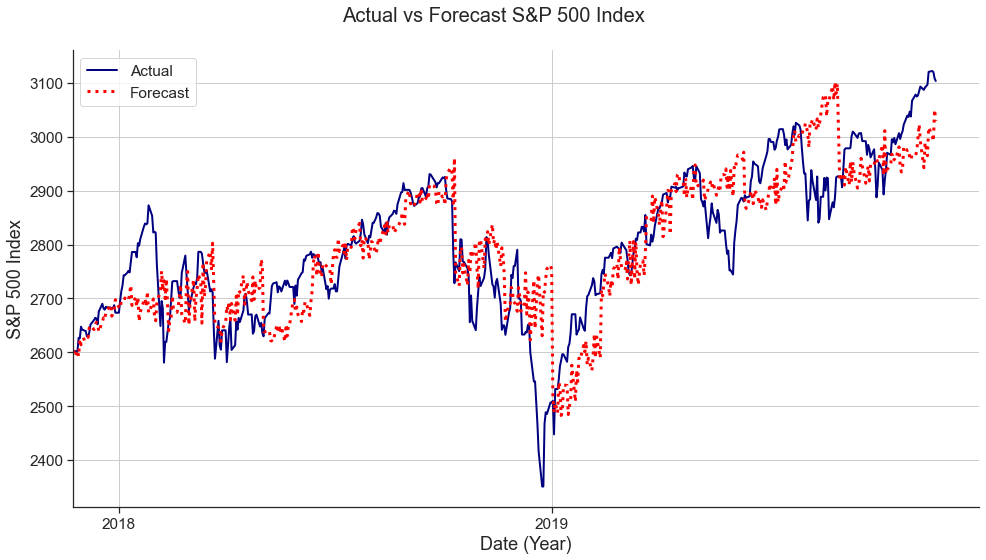

Test RMSE: 81.24


In [ ]:
y_actual, hybrid3_y_fore, hybrid3_rmse = get_forecast(y_pred, y_test)

In [ ]:
test_rmse = mean_squared_error(y_actual, hybrid3_y_fore, squared=False)
test_mape = mean_absolute_percentage_error(y_actual, hybrid3_y_fore)  # MAPE
print((f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))

Test RMSE: 81.24
Test MAPE: 0.02



Analysis:
- The combination of linear regression and random forest gave the best result so far, with test RMSE of 81.24 for the long-term forecast and 16.44 for the short-term (30 days) forecast.
- Combining both models seems to have allowed the models to learn both the trend and any irregular patterns that exists in the time series.

## 8. Neural Networks and LSTM

In [18]:
steps=30
lags=14
n = int(540/steps - 1)
i_list = [0] + list(np.linspace(steps, 540-steps, num=n))
i_list = [int(i) for i in i_list]

### 8.1 Multi-Layer Perceptron

In [19]:
## Use the Helper Functions to Get the Datasets
X_train, X_test, y_train, y_test = prepare_data()
X_train, X_test, y_train, y_test, X_scaler, y_scaler = scale_data(X_train, X_test, y_train, y_test)

In [20]:
X_train.shape

(9188, 308)

In [21]:
y_train.shape

(9188, 30)

In [19]:
## Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [20]:
## Fix the Random Seed for Reproducible Results
from numpy.random import seed
import tensorflow
import random
import os

In [24]:
seed(1)
tensorflow.random.set_seed(1)
random.seed(1)
os.environ['PYTHONHASHSEED']= '0'

## Define the Model
model = Sequential()

In [25]:
## The combination of internal layers was found from going through every possible combinations.

## Set Up the Internal Nodes
model.add(Dense(10, 
                input_dim=308, 
                kernel_initializer='he_uniform', 
                activation='relu'))

## Add the second hidden layer
model.add(Dense(50, 
                activation = 'relu', 
                kernel_initializer='he_uniform'))

## Add the third hidden layer
model.add(Dense(20, 
                activation = 'relu', 
                kernel_initializer='he_uniform'))

# Output layer
model.add(Dense(30,
                activation='linear'))

model.compile(loss='mse', 
              metrics = ['mse'],
              optimizer='adam')

In [26]:
model.fit(X_train, y_train, verbose=1, epochs=100)

Epoch 1/100
288/288 [==============================] - 1s 2ms/step - loss: 0.2864 - mse: 0.2864
Epoch 2/100
288/288 [==============================] - 1s 2ms/step - loss: 0.0125 - mse: 0.0125
Epoch 3/100
288/288 [==============================] - 1s 2ms/step - loss: 0.0085 - mse: 0.0085
Epoch 4/100
288/288 [==============================] - 1s 2ms/step - loss: 0.0068 - mse: 0.0068
Epoch 5/100
288/288 [==============================] - 1s 2ms/step - loss: 0.0061 - mse: 0.0061
Epoch 6/100
288/288 [==============================] - 1s 2ms/step - loss: 0.0058 - mse: 0.0058
Epoch 7/100
288/288 [==============================] - 1s 2ms/step - loss: 0.0060 - mse: 0.0060
Epoch 8/100
288/288 [==============================] - 1s 2ms/step - loss: 0.0051 - mse: 0.0051
Epoch 9/100
288/288 [==============================] - 1s 2ms/step - loss: 0.0049 - mse: 0.0049
Epoch 10/100
288/288 [==============================] - 1s 2ms/step - loss: 0.0047 - mse: 0.0047
Epoch 11/100
288/288 [=================

In [27]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

17/17 [==============================] - 0s 2ms/step


In [28]:
y_train_unscaled = get_unscaled_data(y_train, y_train, y_scaler)
y_fit = get_unscaled_data(y_fit, y_train, y_scaler)
y_pred = get_unscaled_data(y_pred, y_test, y_scaler)

In [29]:
train_rmse = mean_squared_error(y_train_unscaled, y_fit, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n"))

Train RMSE: 24.55



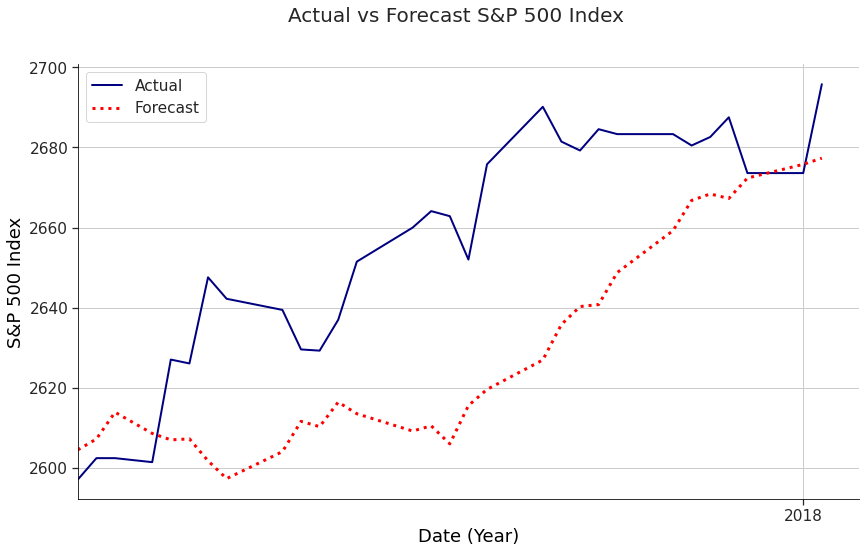

2017-11-23 00:00:00 2018-01-02 00:00:00
Test RMSE: 33.94
Test MAPE: 0.01



In [30]:
snapshot_rmse = get_snapshot(y_pred, y_test)

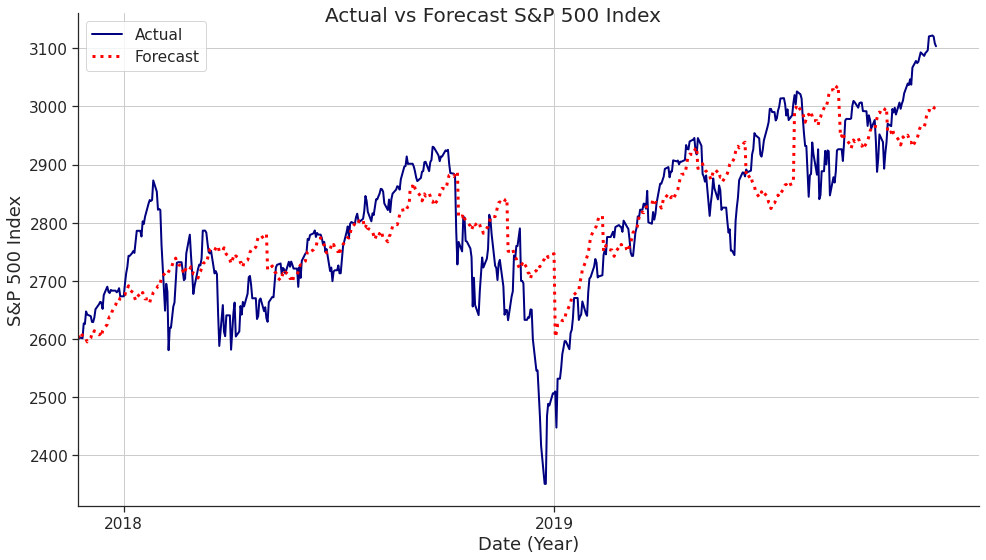

Test RMSE: 84.52


In [31]:
y_actual, mlp_y_fore, mlp_rmse = get_forecast(y_pred, y_test)

Analysis:
- Using the MLP alone seems to give a comparable result to the best hybrid model we found in the previous section.
- Test RMSE = 84.52 for long-term and 33.94 for short-term forecasts.

In [ ]:
## Helper Function for Finding the Best Layer Combinations
def get_best_mlp():
  rmse_list = []

  n_list_1 = []
  n_list_2 = []
  n_list_3 = []

  n_nodes_1 = [10,20,30,40,50]
  n_nodes_2 = [10,20,30,40,50]
  n_nodes_3 = [10,20,30,40,50]

  for n in n_nodes_1:
    for j in n_nodes_2:
      for k in n_nodes_3:
        print(f"Testing: {n}, {j}, {k} nodes...\n")
        
        seed(1)
        tensorflow.random.set_seed(1)
        random.seed(1)
        os.environ['PYTHONHASHSEED']= '0'
        
        ## Define the Model
        model = Sequential()

        ## Set Up the Internal Nodes
        model.add(Dense(n, 
                        input_dim=308, 
                        kernel_initializer='he_uniform', 
                        activation='relu'))

        ## Add the second hidden layer
        model.add(Dense(j, 
                        activation = 'relu', 
                        kernel_initializer='he_uniform'))

        ## Add the second hidden layer
        model.add(Dense(k, 
                        activation = 'relu', 
                        kernel_initializer='he_uniform'))

        ## Output layer
        model.add(Dense(30,
                        activation='linear'))

        model.compile(loss='mse', 
                      metrics = ['mse'],
                      optimizer='adam')
    
        ## Fit & Predict
        model.fit(X_train, y_train, verbose=0, epochs=50)

        y_fit = model.predict(X_train)
        y_pred = model.predict(X_test)

        ## Unscale
        y_train_unscaled = get_unscaled_data(y_train, y_train, y_scaler)
        y_fit = get_unscaled_data(y_fit, y_train, y_scaler)
        y_pred = get_unscaled_data(y_pred, y_test, y_scaler)

        ## Evaluate
        train_rmse = mean_squared_error(y_train_unscaled, y_fit, squared=False)
        y_actual, y_fore, rmse = get_forecast(y_pred, y_test,graph=False)
        test_rmse = mean_squared_error(y_actual, y_fore, squared=False)
        test_mape = mean_absolute_percentage_error(y_actual, y_fore)  # MAPE

        print((f"Number of Nodes: {n}, {j}, {k}\n" f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}\n" f"Test MAPE: {test_mape:.2f}\n"))
        rmse_list.append(test_rmse)
        n_list_1.append(n)
        n_list_2.append(j)
        n_list_3.append(k)

  return rmse_list, n_list_1, n_list_2, n_list_3

In [ ]:
# rmse_list, n_list_1, n_list_2, n_list_3 = get_best_mlp()

Testing: 10, 10, 10 nodes...

17/17 [==============================] - 0s 2ms/step
Test RMSE: 89.93
Number of Nodes: 10, 10, 10
Train RMSE: 30.83
Test RMSE: 89.93
Test MAPE: 0.02

Testing: 10, 10, 20 nodes...

17/17 [==============================] - 0s 2ms/step
Test RMSE: 90.79
Number of Nodes: 10, 10, 20
Train RMSE: 28.04
Test RMSE: 90.79
Test MAPE: 0.03

Testing: 10, 10, 30 nodes...

17/17 [==============================] - 0s 2ms/step
Test RMSE: 91.31
Number of Nodes: 10, 10, 30
Train RMSE: 30.11
Test RMSE: 91.31
Test MAPE: 0.02

Testing: 10, 10, 40 nodes...

17/17 [==============================] - 0s 2ms/step
Test RMSE: 136.04
Number of Nodes: 10, 10, 40
Train RMSE: 28.64
Test RMSE: 136.04
Test MAPE: 0.04

Testing: 10, 10, 50 nodes...

17/17 [==============================] - 0s 2ms/step
Test RMSE: 93.77
Number of Nodes: 10, 10, 50
Train RMSE: 30.77
Test RMSE: 93.77
Test MAPE: 0.03

Testing: 10, 20, 10 nodes...

17/17 [==============================] - 0s 2ms/step
Test RMSE: 100.

In [ ]:
# index = np.argmin(rmse_list)

In [ ]:
# print(f"1st Layer: {n_list_1[index]}\n" f"2nd Layer: {n_list_2[index]}\n" f"3rd Layer: {n_list_3[index]}")

1st Layer: 10
2nd Layer: 50
3rd Layer: 30


In [ ]:
# rmse_list[index]

82.18147712888404

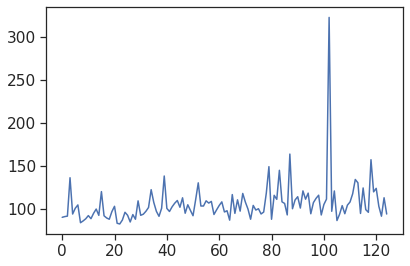

In [ ]:
# plt.plot(rmse_list)

Analysis:
- The best internal node combination was found to be 10, 50, 30 and 10, 50, 20.
- There is some randomness to the MLP that is not easily controllable, which results in different outcomes every time the user retrains and retests the model. After some trial and error, the combination of 10, 50, 20 gave the most consistent result.

### 8.2 LSTM

In [21]:
from numpy import hstack
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [425]:
# split a multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [362]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [31]:
df_copy = df.copy()

In [423]:
# define input sequence
raw_seq = df_copy.close
# choose a number of time steps
n_steps_in, n_steps_out = 14, 30


In [426]:
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

In [427]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [431]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=540, shuffle=False)

In [436]:
seed(1)
tensorflow.random.set_seed(1)
random.seed(1)
os.environ['PYTHONHASHSEED']= '0'

## Define the Model
model = Sequential()

In [437]:
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [438]:
model.fit(X_train, y_train, verbose=1, epochs=100)

Epoch 1/100
287/287 [==============================] - 9s 21ms/step - loss: 170459.6719
Epoch 2/100
287/287 [==============================] - 6s 21ms/step - loss: 16505.1875
Epoch 3/100
287/287 [==============================] - 6s 20ms/step - loss: 2517.1328
Epoch 4/100
287/287 [==============================] - 6s 20ms/step - loss: 2360.4866
Epoch 5/100
287/287 [==============================] - 6s 20ms/step - loss: 2268.8484
Epoch 6/100
287/287 [==============================] - 6s 20ms/step - loss: 2270.7852
Epoch 7/100
287/287 [==============================] - 6s 20ms/step - loss: 2248.7300
Epoch 8/100
287/287 [==============================] - 6s 20ms/step - loss: 2269.7251
Epoch 9/100
287/287 [==============================] - 6s 20ms/step - loss: 3598.1899
Epoch 10/100
287/287 [==============================] - 6s 20ms/step - loss: 2290.9446
Epoch 11/100
287/287 [==============================] - 6s 20ms/step - loss: 2362.3411
Epoch 12/100
287/287 [===========================

In [447]:
# make a prediction
y_pred = model.predict(X_test)


17/17 [==============================] - 0s 8ms/step


In [449]:
y_pred = pd.DataFrame(y_pred, index = df_copy.index[-540:])
y_test = pd.DataFrame(y_test, index = df_copy.index[-540:])

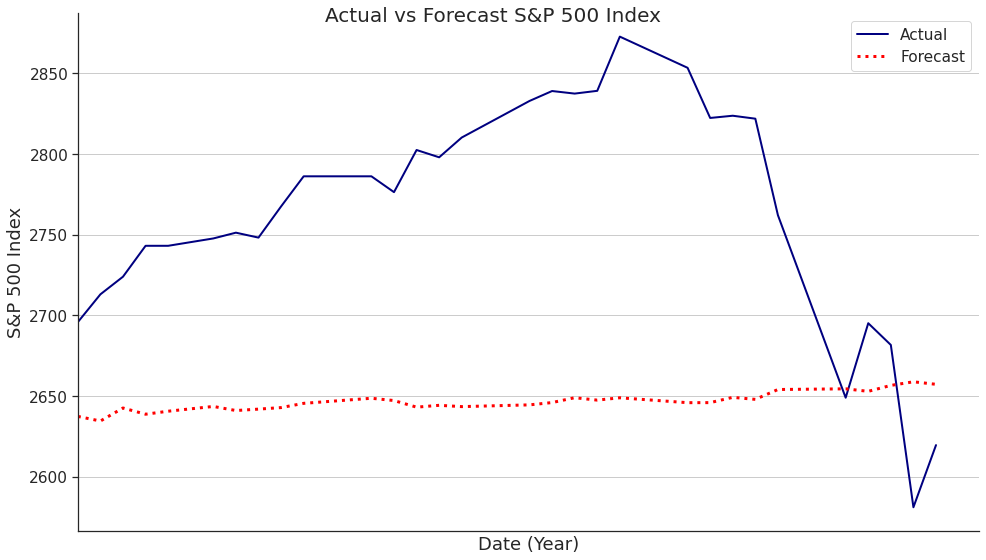

2018-01-02 00:00:00 2018-02-09 00:00:00
Test RMSE: 138.09
Test MAPE: 0.05



In [451]:
snapshot_rmse = get_snapshot(y_pred, y_test)

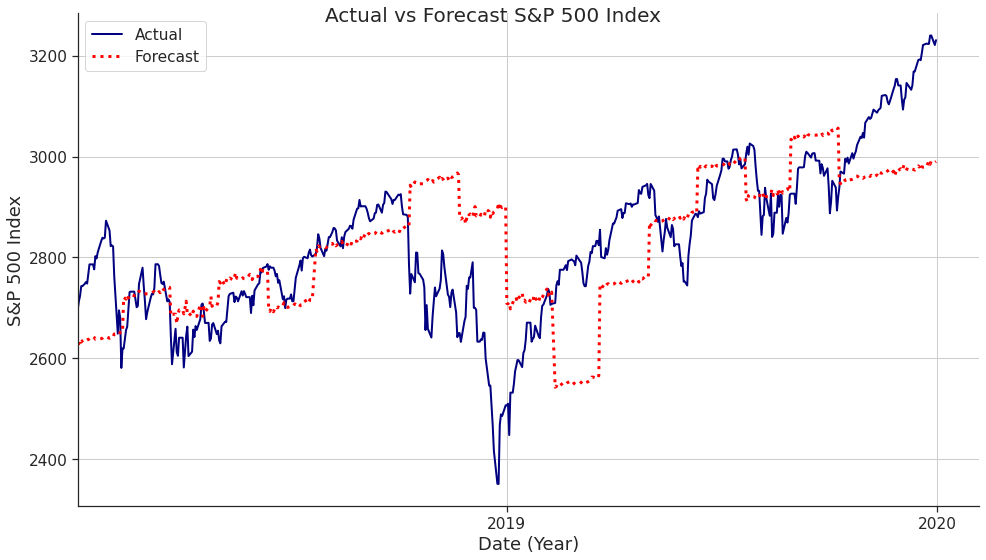

Test RMSE: 136.40


In [450]:
y_actual, lstm_y_fore, lstm_rmse = get_forecast(y_pred, y_test)

Analysis:
- LSTM yielded a similar result as the simple univariate regression model in Section 5.
- Test RMSE: 136.4 (long-term) and 138.09 (short-term).
- This model did not perform as well as I expected, but this may be due to technical issues I had in running the model (the biggest issue was trying to scale the values for training, and then inverse scaling the prediction values back to its original scale. This was not straightforward and was taking up too much time to fix, so it was abandoned)

## 9. Conclusion

We have satisfactorily built a predictive model that can accurately make mid-term and long-term forecasts. The final chosen model is hybrid LR + RF model with a 30-days forecast RMSE of 16.44 and a 2-years forecast RMSE of 81.24. The mean average percentage error for the model is around 0.01, meaning that the average error between the forecasted values and the actual values were around 1%. Therefore, we have met the objective of building an accurate predictive model.
<br>
<br>
We have also streamlined the process of acquiring data and transforming the data to be used by the model by incorporating APIs and user-defined helper functions. This means that there is minimum input and more importantly minimum coding experience required by our stakeholders when they use the model on their own. Therefore, we have also met the objective of automatically acquiring the required data.
<br>
<br>
The source code is made available in GitHub Repository7 for our stakeholders to use.
The next step is to deploy our model as a web-based app. We recommend using Heroku for deployment. Once deployed, the goal is to be able to provide our stakeholders what we call a “one-click forecast” where the model will automatically acquire the required data and make forecasts after a single click. We will need to continually re-train the model every 6-months or more frequently during the time of recession to ensure the accuracy of model forecasts meet our stakeholders’ expectation.
In the meantime, it is also recommended we continue to explore more finetuning of model hyperparameters to see if we can improve the overall accuracy than currently reported in this report.


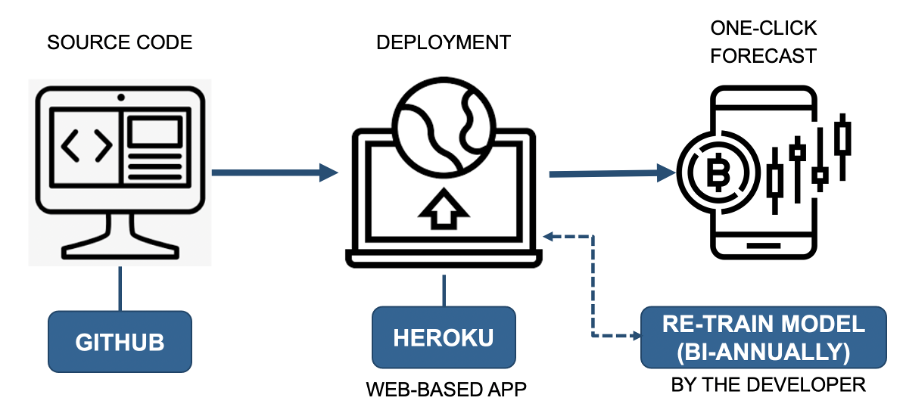